# Analysis

## Importing Libraries and Dataset

In [ ]:
import pandas as pd
# from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
import random
from sklearn.linear_model import LinearRegression


In [ ]:
from IPython.display import display, HTML

def displayHorizontalDataframes(dfs, titles):
    """
    Display a list of pandas dataframes horizontally with titles on top.
    
    Parameters:
    dfs (list): List of pandas DataFrames.
    titles (list): List of titles (strings) corresponding to each DataFrame.
    """
    if len(dfs) != len(titles):
        raise ValueError("The number of dataframes and titles must be the same.")

    # Start a flex container to align content horizontally and center them.
    html = (
        "<div style='display: flex; justify-content: center; "
        "align-items: flex-start;'>"
    )
    
    # Iterate over the dataframes and their corresponding titles.
    for df, title in zip(dfs, titles):
        html += (
            "<div style='margin-left: 20px; margin-right: 20px; text-align: center;'>"
            f"<h3>{title}</h3>"
            f"{df.to_html(classes='dataframe', border=1)}"
            "</div>"
        )
    
    html += "</div>"
    display(HTML(html))

In [3]:
def custom_repr_html(self):
    # Apply a custom style that sets the font size for <td> and <th> elements.
    return self.style.set_table_styles(
        [{'selector': 'td, th', 'props': [('font-size', '12.5px')]}]
    )._repr_html_()

# Override the default _repr_html_ method for all DataFrames.
pd.DataFrame._repr_html_ = custom_repr_html

In [4]:
df = pd.read_csv('../../Stationary/Data/walmart.csv')

## Preliminary Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.set_index(['Date', 'Store']).head(3)

weekly_sales  holiday_flag  temperature  fuel_price  \
date       store                                                        
2010-02-05 1        1643690.90         False        42.31       2.572   
2010-02-12 1        1641957.44          True        38.51       2.548   
2010-02-19 1        1611968.17         False        39.93       2.514   

                         cpi  unemployment  
date       store                            
2010-02-05 1      211.096358         8.106  
2010-02-12 1      211.242170         8.106  
2010-02-19 1      211.289143         8.106

In [ ]:
df.set_index(['Date', 'Store']).tail(3)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
6432  192.327265         8.667  
6433  192.330854         8.667  
6434  192.308899         8.667

In [5]:
def cleaning(df_copy: pd.DataFrame) -> pd.DataFrame:
    df = df_copy.copy(deep=True)
    df['Date'] = pd.to_datetime(df['Date'], format=r"%d-%m-%Y")
    df['Store'] = df['Store'].astype(pd.StringDtype()).astype('category')
    df['Holiday_Flag'] = df['Holiday_Flag'].astype(pd.BooleanDtype())
    df = df.rename(columns={col: col.lower() for col in df.columns})
    return df

df = cleaning(df)

## Final/Major Observations

```{admonition} Final/Major Observations
:class: dropdown

1. There are 45 unique stores and we have data on weekly sales for 143 weeks for each store starting from 5th Feb 2010 to 26 Oct 2012
2. Except holiday_flag, all other variables like weekly_sales, temperature, fuel_price, cpi, unemployment are unique to each store and date. holiday_flag is common for all stores.
3. There are no missing values in the dataset.
4. Holiday_flag is highly imbalanced with only 10% of the data being holiday weeks.
5. From visually inspecting the total sales for each week overlapped with holiday weeks, we can clearly see a seasonal trend. The holiday_flags are mostly set for these occassions:
    - Valentines day or superbowl (2nd week of Feb)
    - Labour day/ back to school (1st or 2nd week of Sept)
    - Thanksgiving and Black Friday (3rd and/or 4th week of Nov around Nov 24th)
    - Christmas and New Years (3rd and/or 4th week of Dec around Dec 24th)
    - Also, very few stores also see boost in Sales for Independence day (1st week of July around July 4th)
6. From visual inspection of the Times series decomposition plot using STL, what I noticed is it cannot properly decompose the sales into a "nice" continuous seasonal component. The seasonal effect is directly due to the recurring holiday sales boots, but they are randomly distributed over the year and repeat yearly. It's not like every month there's a holiday at a fixed interval. They are inconsistently distributed. So, technically the season is 52 weeks long. But, the seasonal effect is not efficiently captured by the STL decomposition.
6. From visual inspection, most sales get boosted by Balck Friday and New Years. Valentines week does see some boost in sales but not as significant as others. Labour day does not seem to have a significant impact on sales.
7. The series looks additive for all stores from visual inspection of plots.
8. Unemployment is highly negatively correlated with cpi for almost all stores.
9. Unemployment is also substantially negatively correlated with fuel_price for almost all stores. Not as strongly correlated as with cpi, but still significant.
10. Store 36 is definitely an odd one out. It's weekly sales show a clear downward trend with no seasonal effects.
11. Unemployment
    - When looking at coorelation coefficients for weekly_sales vs unemployment; Looking at it, the trend component of weekly sales is definitely more correlated with unemployment than regular weekly_sales. But, there's high contrast in how it's correlated. Sometimes it's strongly positive, sometimes it's strongly negative. Few times it's close to zero. So, I'm not sure if it's a good indicator of whether there's a relationship between weekly_sales and unemployment.
12. Consumer Price Index:
    - When looking at weekly_sales and cpi directly, the correlations is insignificant. But, when considering only the trend component with respect to CPI, there seems to be a significant correlation.
    - Most of the correlations are strongly positive. Very few are strongly negative. And even fewer are weakly positive or negative.
    - If for all stores the correlations were in same direction with significant magnitude, then it would hold some meaning. But, it doesn't.
13. Temperature:
    - There is no correlation between weekly_sales and temperature
14. CPI and Fuel price are strongly positively correlated with each other for ALL stores with average Pearson correlation coefficient of 0.814. This is intuitive because fuel pice is generally considered when calculating CPI.
15. Unemployment and CPI are negatively correlated for most stores. For 75% of then stores, the correlation is greater in magnitude than 0.73 and for 85% of the stores it's greater in magnitude than 0.51. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.86
16. Fuel Price and Unemployment are negatively correlated for most stores. This correlation isn't as strong as Unemployment and CPI. For 75% of then stores, the correlation is greater in magnitude than 0.53. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.6
17. PCA on CPI, Unemployment and Fuel Price:
    - The 3 features cpi, unemployment and fuel_price are reduced to 2 principal components which on average (across all stores) explains 97% variance across the 3 features.
    - When I tried reducing the features to just 1 principal component, I got worse results where on average (across all stores) the variance explained was only 83%
```


## Checking if features vary only with date or store too

#### CPI

In [8]:
temp = df.set_index(['store', 'date'])['cpi'].unstack().T.sample(3).apply(lambda x: round(x, 2))
temp[random.sample(temp.columns.to_list(), 10)]

store           21      22       7      41      15      16      25       8  \
date                                                                         
2012-06-29  221.48  142.19  197.79  197.79  138.20  197.79  214.65  225.40   
2011-08-12  215.26  140.09  194.11  194.11  136.14  194.11  208.78  219.01   
2012-03-09  220.70  141.47  196.96  196.96  137.51  196.96  213.87  224.61   

store            4      20  
date                        
2012-06-29  130.76  214.65  
2011-08-12  129.20  208.78  
2012-03-09  130.74  213.87

#### Temperature

In [9]:
temp = df.set_index(['store', 'date'])['temperature'].unstack().T.sample(3)
temp[random.sample(temp.columns.to_list(), 10)]

store          39      8     28     30      2      9      7      4     19  \
date                                                                        
2012-09-28  78.04  71.10  81.22  80.38  79.45  76.80  50.64  71.74  56.81   
2010-10-15  69.96  62.59  75.00  68.61  65.80  67.36  35.86  62.03  51.32   
2010-05-14  77.49  61.35  68.44  73.08  73.31  70.53  41.41  62.35  46.53   

store           6  
date               
2012-09-28  77.82  
2010-10-15  68.93  
2010-05-14  74.95

#### Holidays

In [10]:
ndf = df.set_index(['store', 'date'])['holiday_flag'].unstack().T.astype(int)
for column in ndf.columns[1:]:
    if not (ndf[ndf.columns[0]] == ndf[column]).all():
        print(column)

##### Conclusions/observations

- Except holiday_flag, all other variables like weekly_sales, temperature, fuel_price, cpi, unemployment are unique to each store and date.
- holiday_flag is common for all stores. 

## Univariate and Bivariate Analysis using Ydata Profiling

In [11]:
# for store in df['store'].unique():
#     temp = df.loc[df['store'] == store].drop(columns=['store']).copy()
#     report = ProfileReport(temp, title=f'Store {store}')
#     report.to_file(f'Reports/store_{store}.html', silent=True)

## Miscellaneous Analysis

In [124]:
df['date'].drop_duplicates().dt.year.value_counts().reset_index().sort_values('date').rename(columns={'date':'Year'})

Year  count
1  2010     48
0  2011     52
2  2012     43

The data is incomplete for years 2010 and 2012. So, the yearly cycle needs to be offset while considering 2010 values as the starting point

<Axes: xlabel='date', ylabel='sales'>

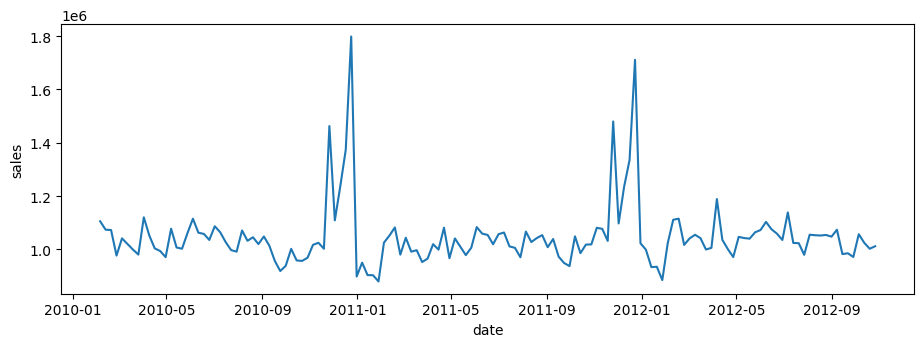

In [26]:
plt.figure(figsize=(11, 3.5)) 
sns.lineplot(
    data=df.pivot_table(index = 'date', columns = 'store', values = 'weekly_sales', observed=True).mean(axis=1).reset_index().rename(columns={0: 'sales'}),
    x='date',
    y='sales',
)

### Checking sales with respect to date and holidays

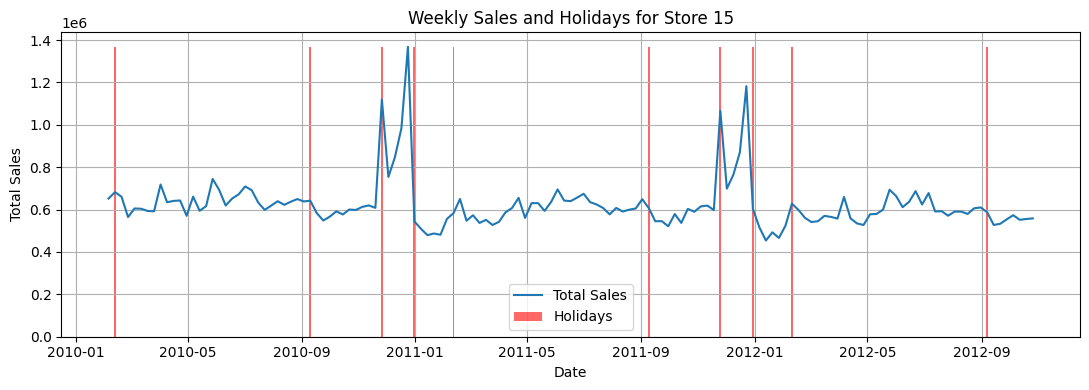

In [126]:

# Pivot the table
tdf = df.pivot_table(index='date', columns='store', values='weekly_sales', observed=True)
store = '15'
tdf['total_sales'] = tdf.sum(axis=1)
tdf['holiday_flag'] = df.loc[df['store'] == store].set_index('date')['holiday_flag']
tdf.reset_index(inplace=True)

# Matplotlib/Seaborn code
plt.figure(figsize=(11, 4))  # Adjust figure size for width

# Line plot for weekly sales
sns.lineplot(x='date', y=store, data=tdf, label='Total Sales')

# Bar plot for holidays
plt.bar(tdf['date'], tdf['holiday_flag'].astype(int) * tdf[store].max(),
        color='red', alpha=0.6, label='Holidays', width=2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Weekly Sales and Holidays for Store ' + store)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [182]:
# Extract the series of holiday dates
holiday_dates = tdf.loc[tdf["holiday_flag"], "date"]

# Create DataFrames for each year
holidays_10 = pd.DataFrame(
    holiday_dates[holiday_dates.dt.year == 2010].reset_index(drop=True)
)
holidays_11 = pd.DataFrame(
    holiday_dates[holiday_dates.dt.year == 2011].reset_index(drop=True)
)
holidays_12 = pd.DataFrame(
    holiday_dates[holiday_dates.dt.year == 2012].reset_index(drop=True)
)

holidays_10.columns = ["date"]
holidays_11.columns = ["date"]
holidays_12.columns = ["date"]

In [183]:
displayHorizontalDataframes([holidays_10, holidays_11, holidays_12], ['Holidays in 2010', 'Holidays in 2011', 'Holidays in 2012'])

#### Observations

- From visually inspecting the weekly_sales, we can clearly see a seasonal trend. The holiday_flags are mostly set for these occassions:
    - Valentines day (Feb 2nd week)
    - Labour day/ back to school (Sep 1st week)
    - Thanksgiving and Black Friday (Nov 24th weeok)
    - Christmas and New Years (Dec 25th week)
    - Also, very few stores also see boost in Sales for Independence day (July 4th week)

- From visual inspection, most sales get boosted by Balck Friday and New Years. Valentines week does see some boost in sales but not as significant as others. Labour day does not seem to have a significant impact on sales.

- Extra and isolated Holiday effects:
    - April 6 (specifically 2012)
    - August 6
    - June 4 (specifically 2011, 2012)

### Store wise Aggregate metrics

In [28]:
weekly_sales = df.pivot(index='date', columns='store', values='weekly_sales')
wsd = weekly_sales.describe()

## Unemployment Rate Analysis
   - Investigate whether the weekly sales are affected by the unemployment rate.
   - Identify which stores are suffering the most if an effect exists.

### Sales and Unemployment comparison

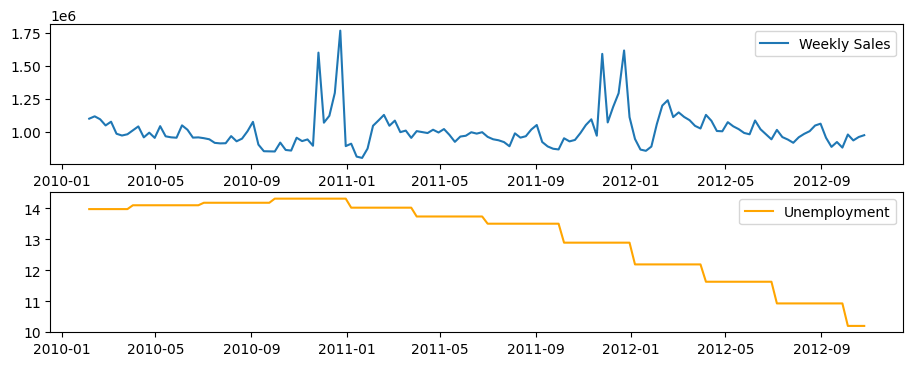

In [17]:
df_store = df[df['store'] == '12']

fig, ax = plt.subplots(2, 1, figsize=(11, 4))
ax[0].plot(df_store['date'], df_store['weekly_sales'], label='Weekly Sales')
ax[1].plot(df_store['date'], df_store['unemployment'], label='Unemployment', color='orange')
ax[0].legend()
ax[1].legend()
plt.show()


From Visual inspection of Weekly sales and Unemployment side-byside, no direct correlation can be observed between sales and unemployment rate. However, seasonal decompose might tell us something

Pearson Correlation between unemployment and weekly sales: -0.11252795058812329
Spearman Correlation between unemployment and weekly sales: -0.1605059665705267
Kendall Correlation between unemployment and weekly sales: -0.11418063280775571


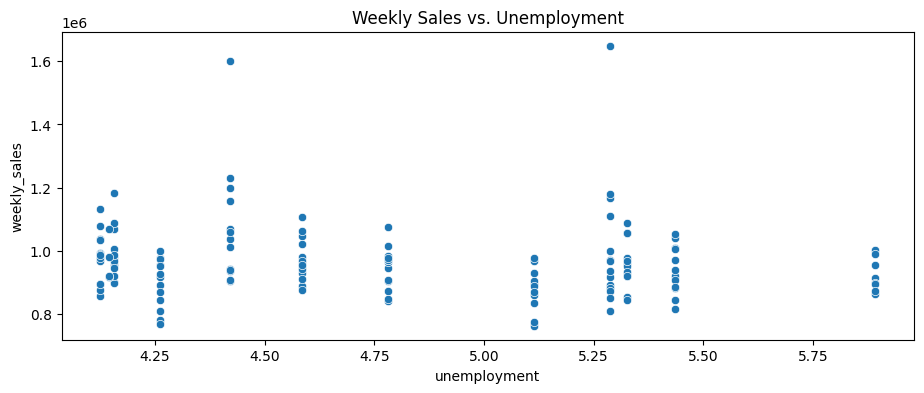

In [29]:
df_store = df[df['store'] == '40']

plt.figure(figsize=(11, 4)) 
sns.scatterplot(x='unemployment', y='weekly_sales', data=df_store)
plt.title('Weekly Sales vs. Unemployment')
# plt.show()

pearson = df_store['weekly_sales'].corr(df_store['unemployment'], method='pearson')
print(f"Pearson Correlation between unemployment and weekly sales: {pearson}")

spearman = df_store['weekly_sales'].corr(df_store['unemployment'], method='spearman')
print(f"Spearman Correlation between unemployment and weekly sales: {spearman}")

kendall = df_store['weekly_sales'].corr(df_store['unemployment'], method='kendall')
print(f"Kendall Correlation between unemployment and weekly sales: {kendall}")


### Correlation between unemployment rate and sales

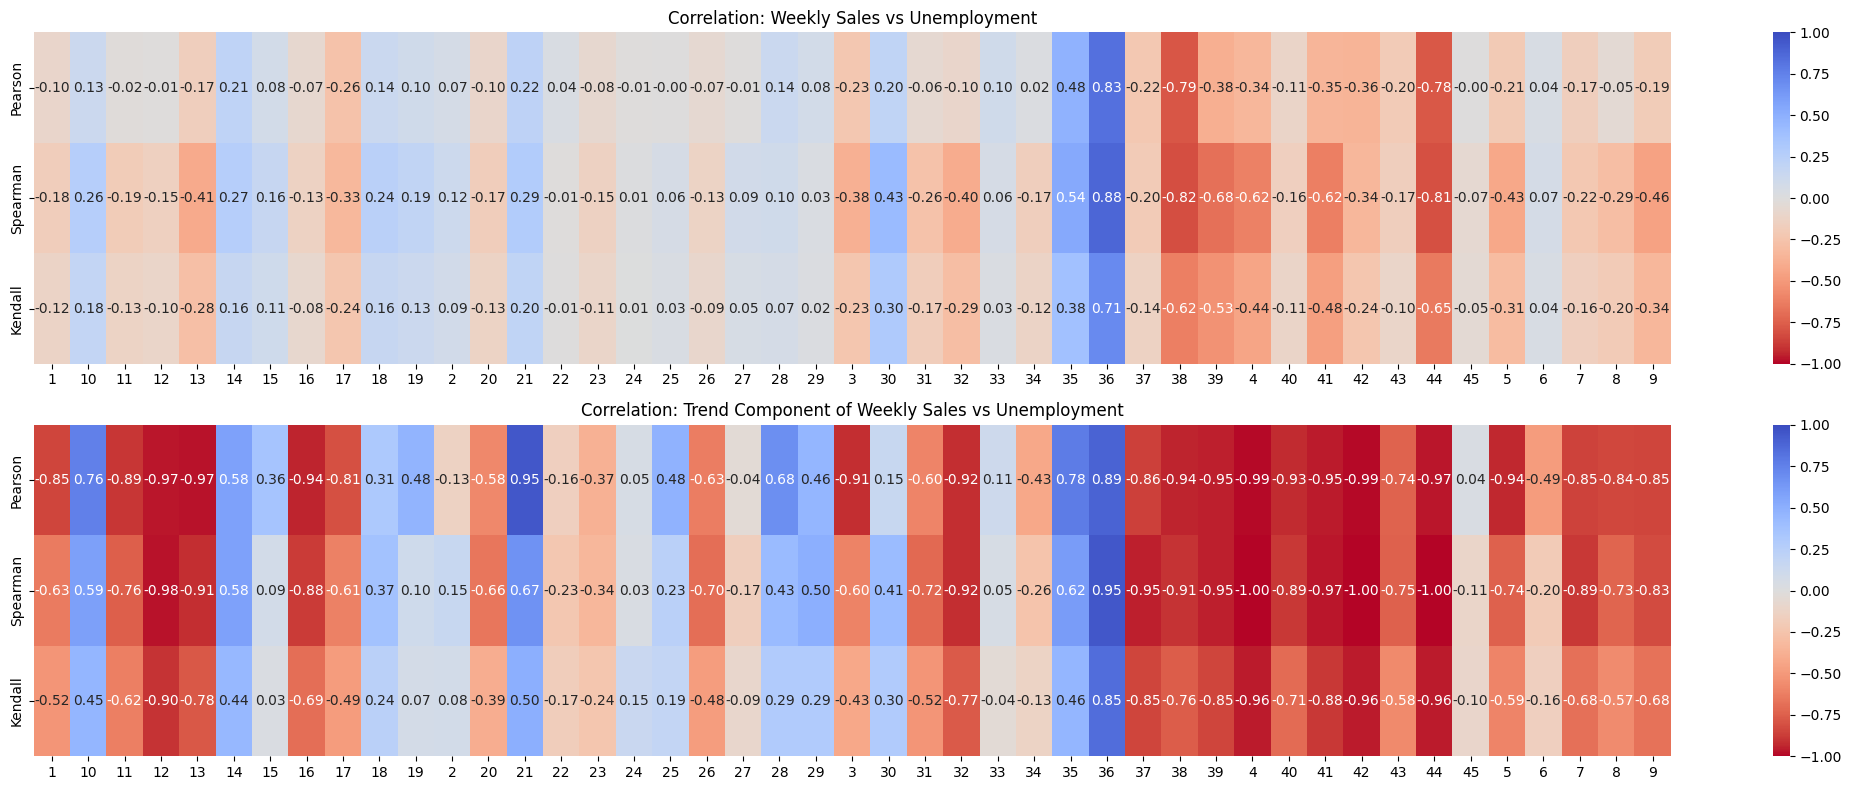

In [27]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and unemployment
    y = df_store['weekly_sales']
    unemployment = df_store['unemployment']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(unemployment, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(unemployment, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(unemployment, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs Unemployment)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(unemployment, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(unemployment, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(unemployment, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(21, 8), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs Unemployment Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation: Weekly Sales vs Unemployment")

# Trend vs Unemployment Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs Unemployment")

# Adjust layout
plt.tight_layout()
plt.show()


### Observations
Looking at it, the trend component of weekly sales is definitely more correlated with unemployment than regular weekly_sales. But, there's high contrast in how it's correlated. For most of the stores, it's strongly negative. For some other stores it's strongly positive. Few times it's close to zero. So, I'm not sure if it's a good indicator of whether there's a relationship between weekly_sales and unemployment.

## Decomposition of Store-wise Weekly Sales

### STL Decomposition of weekly_sales for selected stores

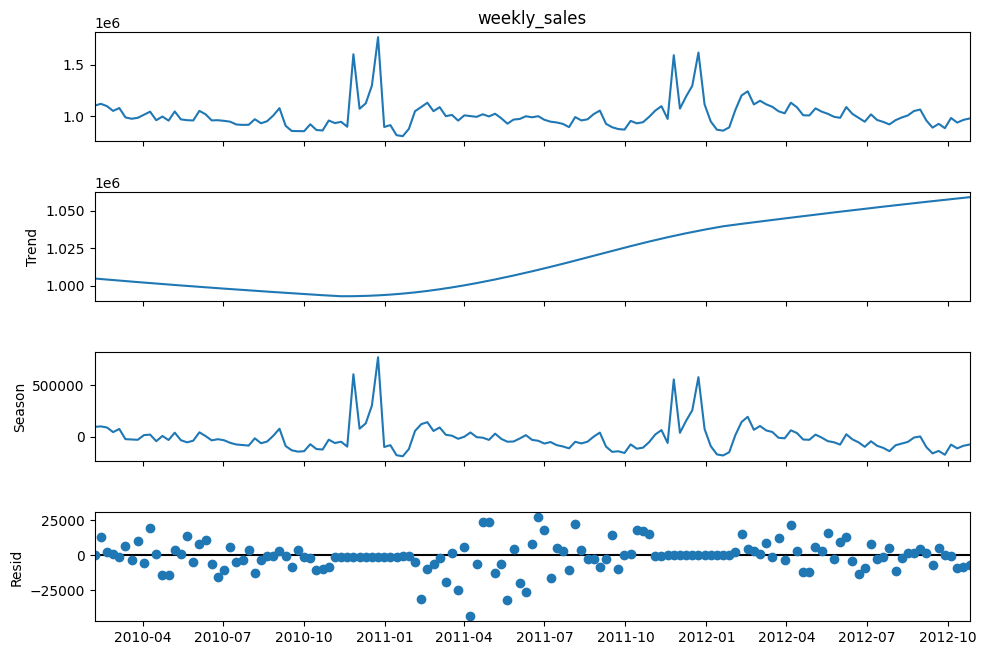

In [20]:
store = '12'
df_store = df[df['store'] == store]
df_store = df_store.sort_values('date').set_index('date')  # ensure chronological order

# Set weekly_sales as the target series
y = df_store['weekly_sales']

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, seasonal=53, robust=False, low_pass = 53)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(11, 7)


### MSTL to capture monthly and annual seasonality separately?

In [21]:

df_store = df[df['store'] == '12']
df_store = df_store.sort_values('date').set_index('date')  # ensure chronological order

# Set weekly_sales as the target series
y = df_store['weekly_sales']

mstl = MSTL(y, periods=[4, 52], iterate=5)
result = mstl.fit()

fig = result.plot()
fig.set_size_inches(11, 7)
plt.show()

### Observations

From visual inspection of the Times series decomposition plot using STL and MSTL, what I noticed is it cannot properly decompose the sales into a "nice" continuous seasonal component. The seasonal effect is directly due to the recurring holiday sales boots, but they are randomly distributed over the year and repeat yearly. It's not like every month there's a holiday at a fixed interval. They are inconsistently distributed. So, technically the season is 52 weeks long. But, the seasonal effect is not efficiently captured by the STL decomposition.



## Temperature Effect
- Examine if temperature influences weekly sales.

In [ ]:
store = '11'
df_store = df[df['store'] == store].sort_values('date').set_index('date')

# Create stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(11, 4))
ax1.plot(df_store.index, df_store['weekly_sales'], color='tab:blue')
ax1.set(ylabel='Sales', title='Sales and Temperature')
ax2.plot(df_store.index, df_store['temperature'], color='tab:red')
ax2.set(xlabel='Date', ylabel='Temperature')
plt.tight_layout()
plt.show()

### Checking correlation between weekly_sales and temperature

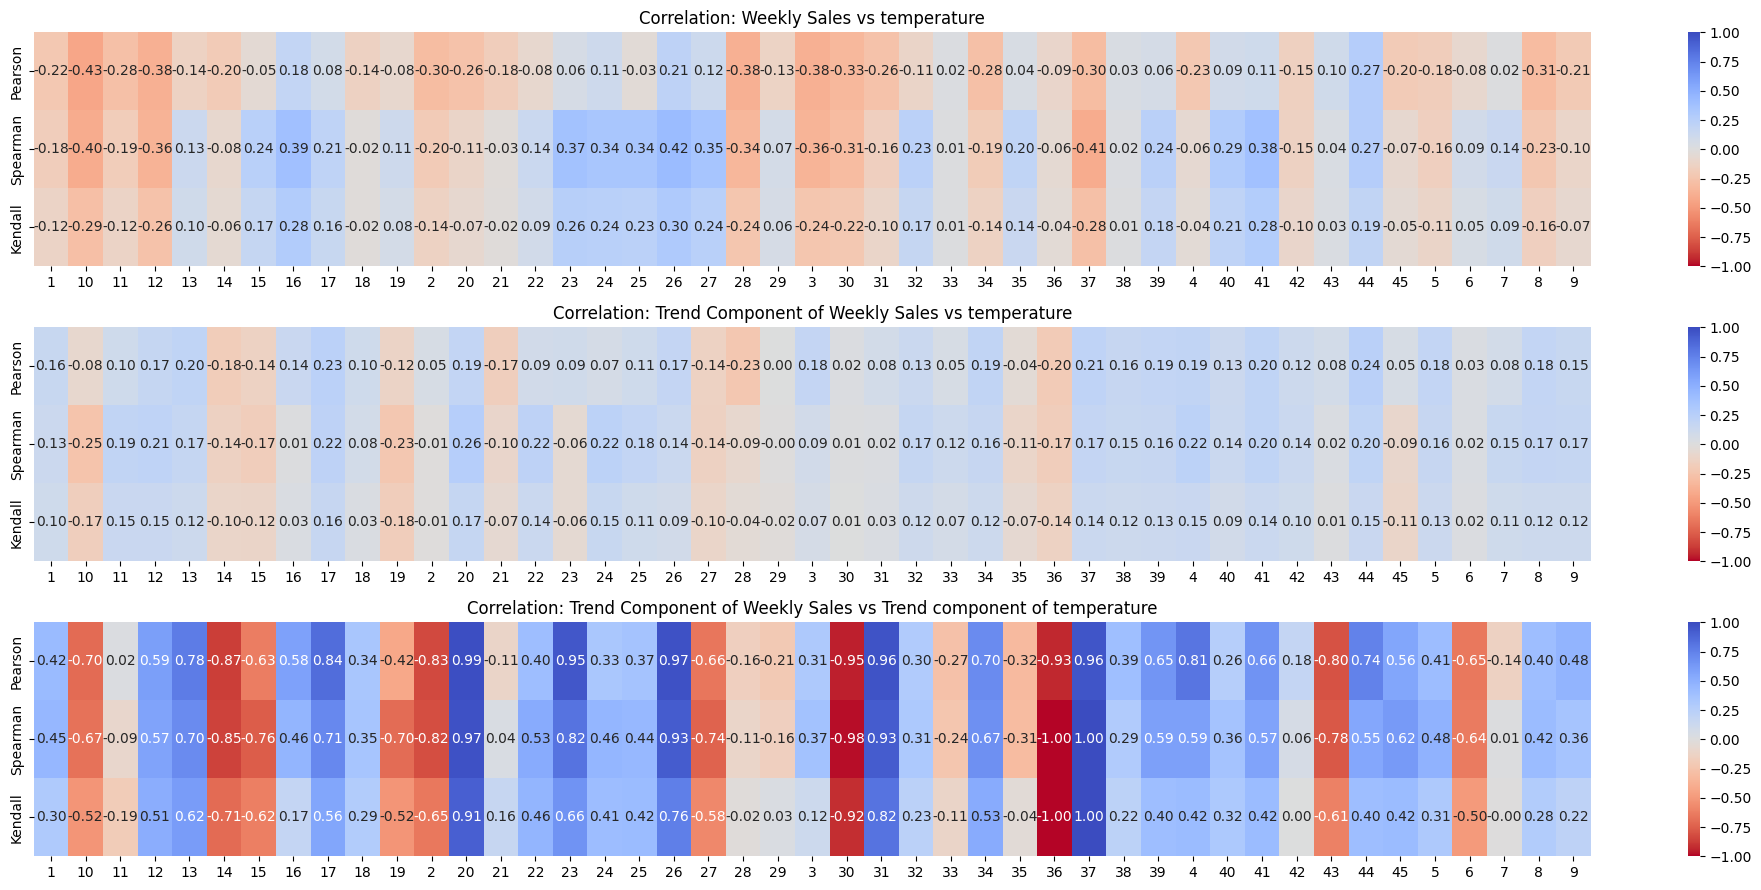

In [24]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_double_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and temperature
    y = df_store['weekly_sales']
    temperature = df_store['temperature']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(temperature, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(temperature, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(temperature, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs temperature)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(temperature, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(temperature, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(temperature, method='kendall')

    # Perform STL decomposition
    stl2 = STL(df_store['temperature'], seasonal=53)  # Assuming yearly seasonality
    result = stl2.fit()
    
    # Extract trend component
    df_store['temperature_trend'] = result.trend
    
    # Compute correlations (Trend vs temperature)
    correlation_double_trend.loc['Pearson', store] = df_store['trend'].corr(df_store['temperature_trend'], method='pearson')
    correlation_double_trend.loc['Spearman', store] = df_store['trend'].corr(df_store['temperature_trend'], method='spearman')
    correlation_double_trend.loc['Kendall', store] = df_store['trend'].corr(df_store['temperature_trend'], method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)
correlation_double_trend = correlation_double_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(20, 9), gridspec_kw={'height_ratios': [1, 1, 1]})

# Sales vs temperature Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation: Weekly Sales vs temperature")

# Trend vs temperature Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs temperature")

# Trend vs temperature trend Heatmap
sns.heatmap(correlation_double_trend, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[2], vmin=-1, vmax=1)
axes[2].set_title("Correlation: Trend Component of Weekly Sales vs Trend component of temperature")

# Adjust layout
plt.tight_layout()
plt.show()

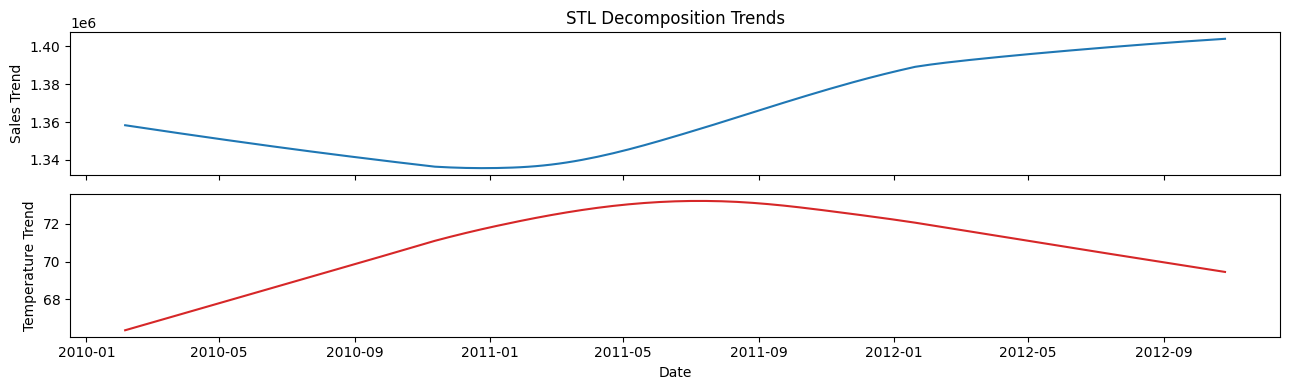

In [11]:
store = '11'
df_store = df[df['store'] == store].sort_values('date').set_index('date')
# Perform STL decomposition for both series
decomp_sales = STL(df_store['weekly_sales'], period=52, seasonal = 53, robust=False).fit()
decomp_temp = STL(df_store['temperature'], period=52, seasonal = 53, robust=False).fit()

# Create stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13, 4))
ax1.plot(df_store.index, decomp_sales.trend, color='tab:blue')
ax1.set(ylabel='Sales Trend', title='STL Decomposition Trends')
ax2.plot(df_store.index, decomp_temp.trend, color='tab:red')
ax2.set(xlabel='Date', ylabel='Temperature Trend')
plt.tight_layout()
plt.show()

#### Observations

- From visual inspection of the correlation heatmaps, weekly sales are definitely not correlated with temperature.
- No need for further hypothesis testing to determine if there is a relationship between temperature and weekly sales.

### Seasonal Decomposition of Temperature

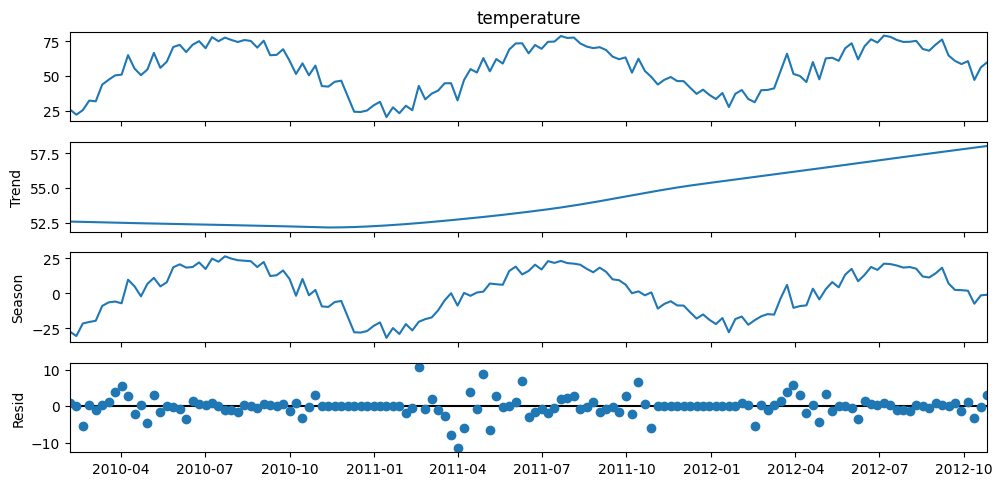

In [24]:
store = '20'
df_store = df[df['store'] == store].sort_values('date').set_index('date')

# Set weekly_sales as the target series
y = df_store['temperature']

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, seasonal=53, robust=False, low_pass = 53)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(11, 5)


#### Observations

- From visual inspection, temperature is obviously seasonal, with peaks in summer (American season)

## Consumer Price Index

### Checking correlation between weekly_sales and its trend component with CPI

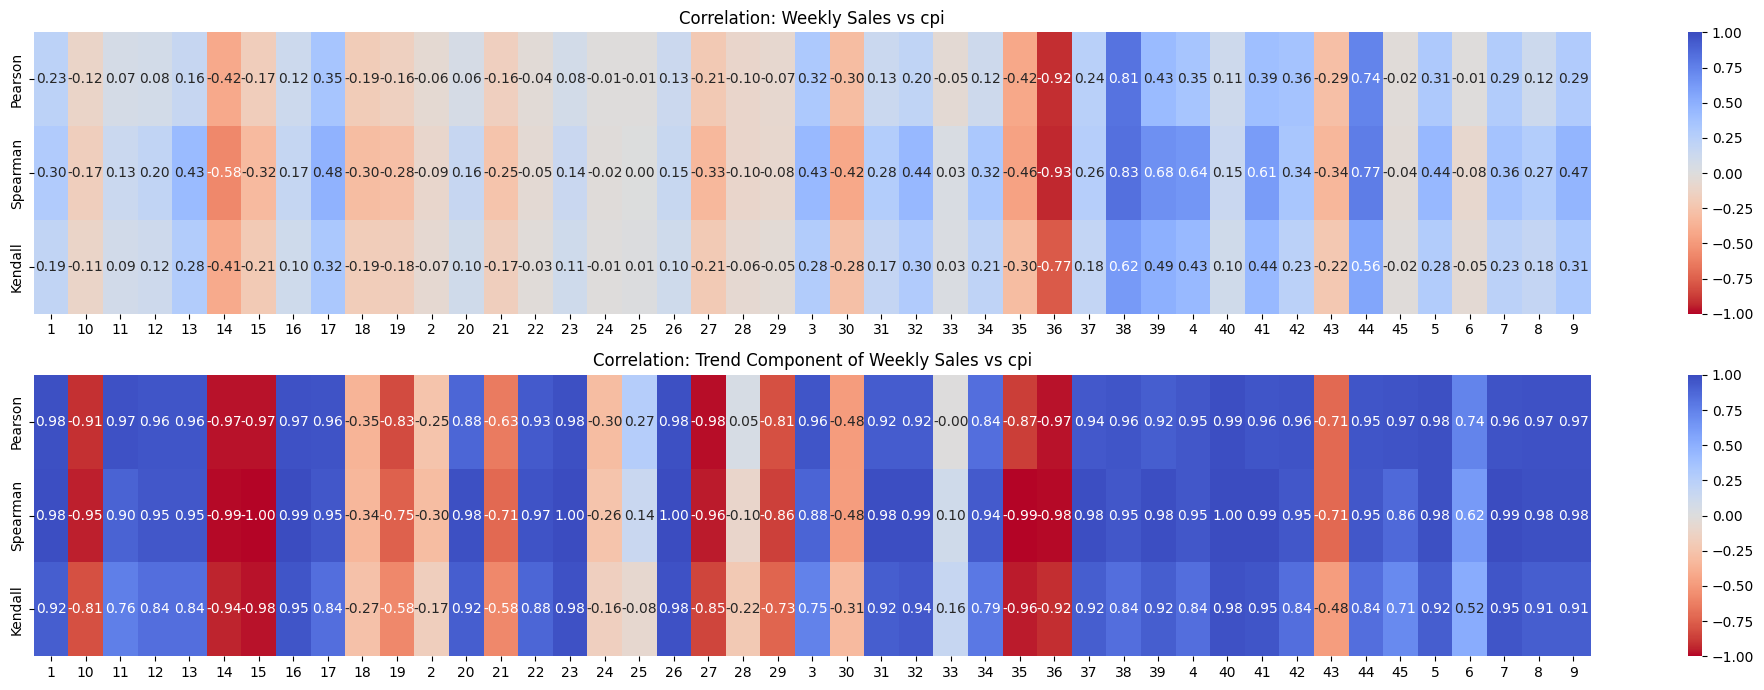

In [20]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and cpi
    y = df_store['weekly_sales']
    cpi = df_store['cpi']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(cpi, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(cpi, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(cpi, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53, period = 52, robust=True)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs cpi)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(cpi, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(cpi, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(cpi, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs cpi Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation: Weekly Sales vs cpi")

# Trend vs cpi Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm_r', annot=True, fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs cpi")

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
store = '4'
df_store = df[df['store'] == store].sort_values('date').set_index('date')
# Perform STL decomposition for both series
decomp_sales = STL(df_store['weekly_sales'], period=52, seasonal = 53, robust=False).fit()
# decomp_temp = STL(df_store['cpi'], period=52, seasonal = 53, robust=False).fit()
cpi = df_store['cpi']

# Create stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(11, 5))
ax1.plot(df_store.index, df_store['weekly_sales'], color='tab:blue')
ax1.set(ylabel='Sales', title='Weekly Sales')
ax2.plot(df_store.index, decomp_sales.trend, color='tab:red')
ax2.set(ylabel='Sales Trend', title='Sales STL Decomposition Trends')
ax3.plot(df_store.index, cpi, color='tab:green')
ax3.set(xlabel='Date', ylabel='cpi', title='CPI')
plt.tight_layout()
plt.show()

### Observations
- When looking at weekly_sales and cpi directly, the correlations is insignificant. But, when considering only the trend component with respect to CPI, there seems to be a significant correlation.
- Most of the correlations are strongly positive. Very few are strongly negative. And even fewer are weakly positive or negative.
- If for all stores the correlations were in same direction with significant magnitude, then it would hold some meaning. But, it doesn't.

## Fuel Price

### Checking correlation between weekly_sales and its trend component with Fuel Price

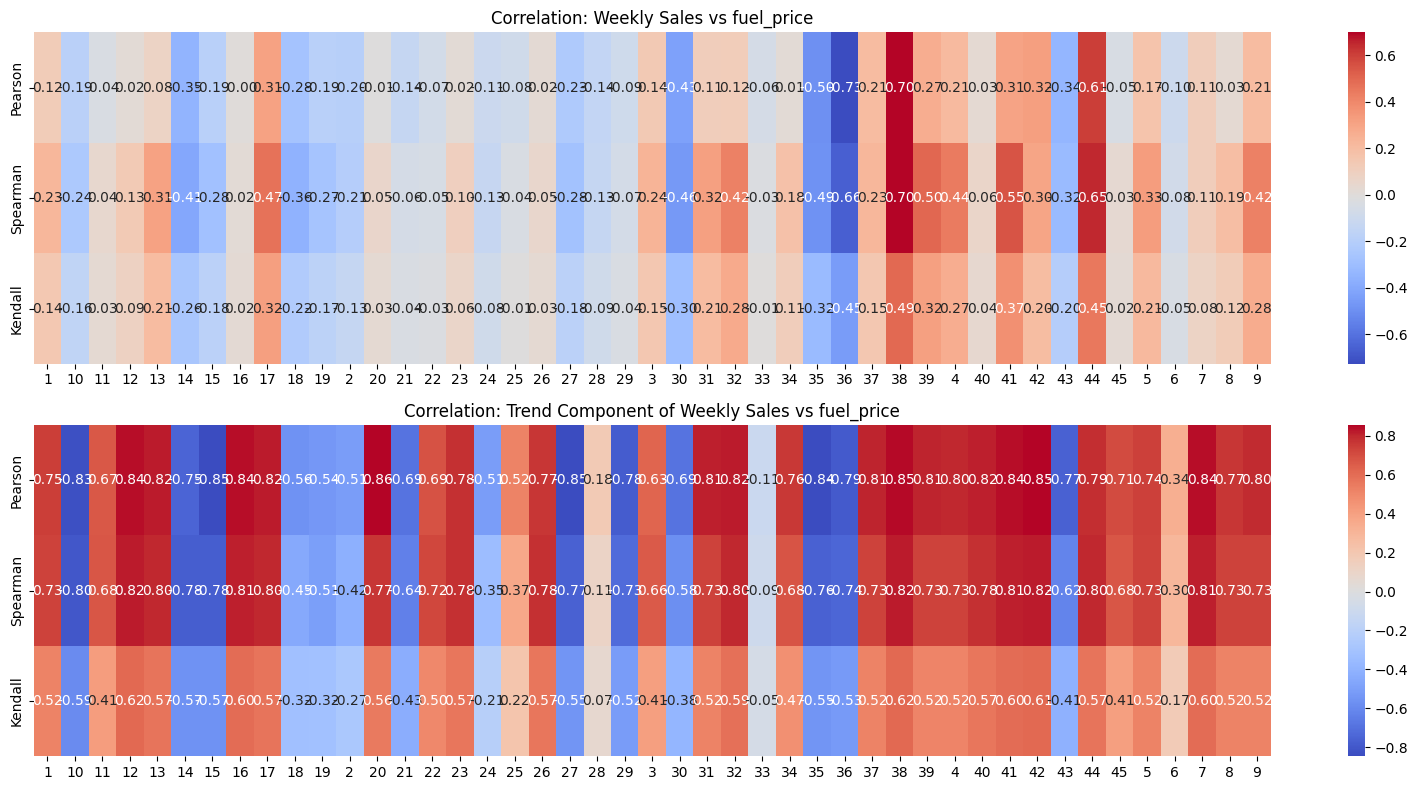

In [28]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and fuel_price
    y = df_store['weekly_sales']
    fuel_price = df_store['fuel_price']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(fuel_price, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(fuel_price, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(fuel_price, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53, period = 52, robust=True)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs fuel_price)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(fuel_price, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(fuel_price, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(fuel_price, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs fuel_price Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation: Weekly Sales vs fuel_price")

# Trend vs fuel_price Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs fuel_price")

# Adjust layout
plt.tight_layout()
plt.show()

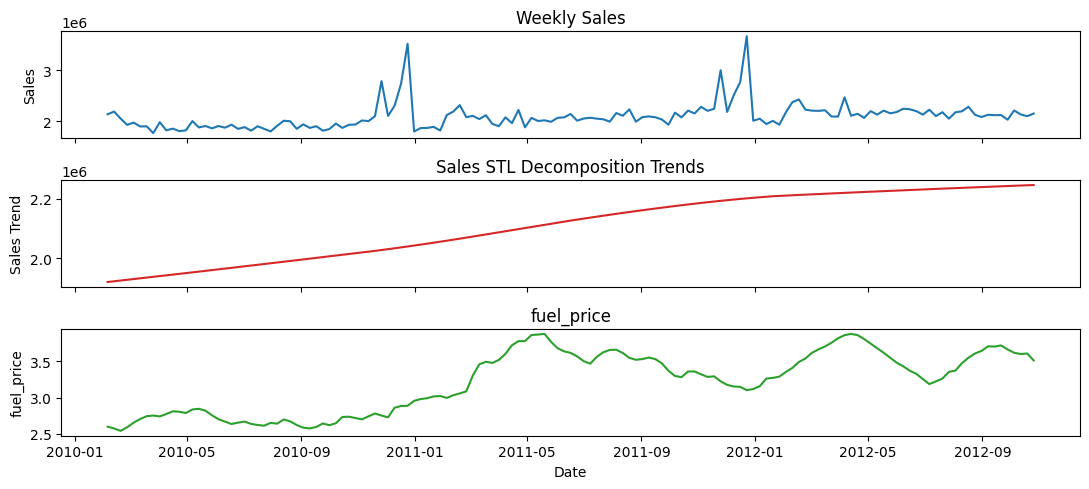

In [12]:
store = '4'
df_store = df[df['store'] == store].sort_values('date').set_index('date')
# Perform STL decomposition for both series
decomp_sales = STL(df_store['weekly_sales'], period=52, seasonal = 53, robust=False).fit()
# decomp_temp = STL(df_store['cpi'], period=52, seasonal = 53, robust=False).fit()
fuel_price = df_store['fuel_price']

# Create stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(11, 5))
ax1.plot(df_store.index, df_store['weekly_sales'], color='tab:blue')
ax1.set(ylabel='Sales', title='Weekly Sales')
ax2.plot(df_store.index, decomp_sales.trend, color='tab:red')
ax2.set(ylabel='Sales Trend', title='Sales STL Decomposition Trends')
ax3.plot(df_store.index, fuel_price, color='tab:green')
ax3.set(xlabel='Date', ylabel='fuel_price', title='fuel_price')
plt.tight_layout()
plt.show()

### Observations

- Similar to CPI, Fuel Price also for most stores seems to have a strong positive correlation with the sales.
- However, similar to CPI, Fuel Price some of the stores seems to have a negative or insignificant correlation with the sales.
- So, Fuel Price is not a good "global" indicator of the sales.

## Store Performance Analysis

Performance metrics:

1. Average sales:
    - This won't be a good metric as the scale of sales differs across stores.
    - But, it can be a good starting point.

2. Total relative growth irrespective of seasons and trends
    - Basically percentage growth of sales from first week to last week.
    - This is relatively a better metric compared to the previous one. But, it might still be susceptible to volatility in first and last weeks.

3. Total relative growth in terms of trend only
    - What this metric does is fits a linear regression model to the growth of sales over time.
    - And then, the slope of the regression line is this metric.
    - This is a better metric than both the previous ones, because it accounts for all the data along with its trend.

4. Stability/volatility of sales
    - This metric analyzes the volatility of sales relative to the trend.
    - It is measured by the standard deviation of the residuals of seasonal decomposition of sales.
    - Note: Since the scale of sales differs across stores, I normalize the residuals to bring them on scale of 1 to -1.
    - Then their standard deviation is multiplied by 100 to give us final percentage volatility.

5. Composite score based on all the above metrics
    - This is the final metric that combines all the above metrics.
    - It is calculated by taking the weighted average of all the metrics.
    - The weights are based on the importance of each metric.
        - Average sales: 5%
        - Relative percentage growth: 25%
        - Linear Trend slope: 60%
        - Volatility: 10%

### Calculating all metrics and corresponding store ranks

In [223]:
stores = df['store'].unique()
performance_records = []

for store_id in stores:
    # 1. Subset data
    df_store = df.loc[df['store'] == store_id].copy()
    df_store = df_store.sort_values(by='date').set_index('date')
    
    # 3. Decompose using STL (assuming ~52-week season)
    stl = STL(df_store['weekly_sales'], period=52, robust=False)
    res = stl.fit()
    
    df_store['trend'] = res.trend
    df_store['seasonal'] = res.seasonal
    df_store['remainder'] = res.resid
    
    # 4. Compute Trend Slope (via Linear Regression)
    # Create a numeric index for regression
    df_store['t'] = np.arange(len(df_store))
    model = LinearRegression()
    model.fit(df_store[['t']], df_store['trend'])
    slope = model.coef_[0]
    
    # 5. Compute % Growth from first to last
    # start_trend = (df_store['trend'] + df_store['remainder']).iloc[0]
    # end_trend   = (df_store['trend'] + df_store['remainder']).iloc[-1]
    start_trend = df_store['trend'].iloc[0]
    end_trend   = df_store['trend'].iloc[-1]
    pct_growth  = ((end_trend - start_trend) / start_trend) * 100 if start_trend != 0 else np.nan
    
    # 6. Compute remainder volatility
    # Compute the minimum and maximum of the residuals for the current store
    res_min = df_store['remainder'].min()
    res_max = df_store['remainder'].max()

    # Apply min-max normalization to map residuals to the range [-1, 1]
    if res_max - res_min != 0:
        df_store['norm_remainder'] = 2 * (
            (df_store['remainder'] - res_min) / (res_max - res_min)
        ) - 1
    else:
        # If all residuals are the same, assign 0 (their normalized value)
        df_store['norm_remainder'] = 0

    # Now compute the standard deviation of the normalized residuals,
    # and multiply by 100 to express it as a percentage volatility.
    volatility_norm_percent = df_store['norm_remainder'].std() * 100
    
    # 7. Collect performance metrics
    performance_records.append({
        'store': store_id,
        'avg_sales': df_store['weekly_sales'].mean(),
        'trend_slope': slope,
        'pct_growth': pct_growth,
        'pct_volatility': volatility_norm_percent
    })

performance_df = pd.DataFrame(performance_records)

In [224]:
def rank_performance(performance_df):
    # Higher is better
    performance_df['rank_avg_sales'] = performance_df['avg_sales'].rank(method='dense', ascending=False)
    performance_df['rank_slope'] = performance_df['trend_slope'].rank(method='dense', ascending=False)
    performance_df['rank_pct_growth'] = performance_df['pct_growth'].rank(method='dense', ascending=False)
    
    # Lower is better for volatility
    performance_df['rank_volatility'] = performance_df['pct_volatility'].rank(method='dense', ascending=True)
    
    # Example: Weighted sum of ranks
    performance_df['overall_rank_score'] = (
        performance_df['rank_avg_sales']*0.05 +
        performance_df['rank_slope']*0.6 +
        performance_df['rank_pct_growth']*0.25 + 
        performance_df['rank_volatility']*0.1
    )
    
    performance_df['overall_rank'] = performance_df['overall_rank_score'].rank(method='dense', ascending=True)
    return performance_df

performance_df = rank_performance(performance_df)

performance_df['avg_sales'] = performance_df['avg_sales'].astype(int)
performance_df['pct_growth'] = performance_df['pct_growth'].round(2)
performance_df['trend_slope'] = performance_df['trend_slope'].round(2)
performance_df['pct_volatility'] = performance_df['pct_volatility'].round(6)
for column in [column for column in performance_df.columns if 'rank' in column]:
    performance_df[column] = performance_df[column].astype(int)

In [225]:
performance_df.head(5)

store  avg_sales  trend_slope  pct_growth  pct_volatility  rank_avg_sales  \
0     1    1555264      1127.12       10.58       26.402651               9   
1     2    1925751      -184.00       -1.09       25.439569               5   
2     3     402704       381.56       13.39       20.941098              40   
3     4    2094712      2627.79       18.64       22.665105               2   
4     5     318011       348.75       16.09       22.180238              43   

   rank_slope  rank_pct_growth  rank_volatility  overall_rank_score  \
0           5               12               35                   9   
1          36               30               31                  32   
2          20               11                9                  17   
3           1                6               15                   3   
4          21                9               12                  18   

   overall_rank  
0             7  
1            34  
2            18  
3             2  
4            19

### Average Weekly Sales

In [196]:
store_sales_summary = (
    performance_df[['avg_sales', 'rank_avg_sales', 'store']].copy()
)
store_sales_summary.sort_values('rank_avg_sales', ascending=True, inplace=True)
store_sales_summary.set_index('store', inplace=True)

displayHorizontalDataframes(
    [store_sales_summary.head(5), store_sales_summary.tail(5)],
    ['Top 5 Best performing stores', 'Bottom 5 Worst performing stores'],
)

In [197]:
print(
    "Total sales difference between Top performer and worst performer",
    (store_sales_summary['avg_sales'].head(1).values[0] - store_sales_summary['avg_sales'].tail(1).values[0])
)

Total sales difference between Top performer and worst performer 1847815


In [167]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='avg_sales', ascending=False).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='avg_sales',
    order=sorted_df['store']
)
plt.title('Average Weekly Sales by Store')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Percentage Growth in Sales

In [198]:
store_sales_summary = (
    performance_df[['pct_growth', 'rank_pct_growth', 'store']].copy()
)
store_sales_summary.sort_values('rank_pct_growth', ascending=True, inplace=True)
store_sales_summary.set_index('store', inplace=True)

displayHorizontalDataframes(
    [store_sales_summary.head(5), store_sales_summary.tail(5)],
    ['Top 5 Best performing stores', 'Bottom 5 Worst performing stores'],
)

In [204]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='pct_growth', ascending=False).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='pct_growth',
    order=sorted_df['store']
)
plt.title('Percentage Weekly Sales Growth')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.grid(True)
plt.show()

### Linear growth in terms of Trend of Weekly Sales

In [205]:
store_sales_summary = (
    performance_df[['trend_slope', 'rank_slope', 'store']].copy()
)
store_sales_summary.sort_values('rank_slope', ascending=True, inplace=True)
store_sales_summary.set_index('store', inplace=True)

displayHorizontalDataframes(
    [store_sales_summary.head(5), store_sales_summary.tail(5)],
    ['Top 5 Best performing stores', 'Bottom 5 Worst performing stores'],
)

In [206]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='trend_slope', ascending=False).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='trend_slope',
    order=sorted_df['store']
)
plt.title('Linear growth in terms of Trend of Sales')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.grid(True)
plt.show()

### Volatility of Sales

In [219]:
store_sales_summary = (
    performance_df[['pct_volatility', 'rank_volatility', 'store']].copy()
)
store_sales_summary.sort_values('rank_volatility', ascending=True, inplace=True)
store_sales_summary.set_index('store', inplace=True)

displayHorizontalDataframes(
    [store_sales_summary.head(5), store_sales_summary.tail(5)],
    ['Top 5 Best performing stores', 'Bottom 5 Worst performing stores'],
)

In [222]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='pct_volatility', ascending=True).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='pct_volatility',
    order=sorted_df['store']
)
plt.title('Percentage of weekly sales volatility')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.grid(True)
plt.show()

### Composite Metric

In [226]:
store_sales_summary = (
    performance_df[['overall_rank_score', 'overall_rank', 'store']].copy()
)
store_sales_summary.sort_values('overall_rank', ascending=True, inplace=True)
store_sales_summary.set_index('store', inplace=True)

displayHorizontalDataframes(
    [store_sales_summary.head(5), store_sales_summary.tail(5)],
    ['Top 5 Best performing stores', 'Bottom 5 Worst performing stores'],
)

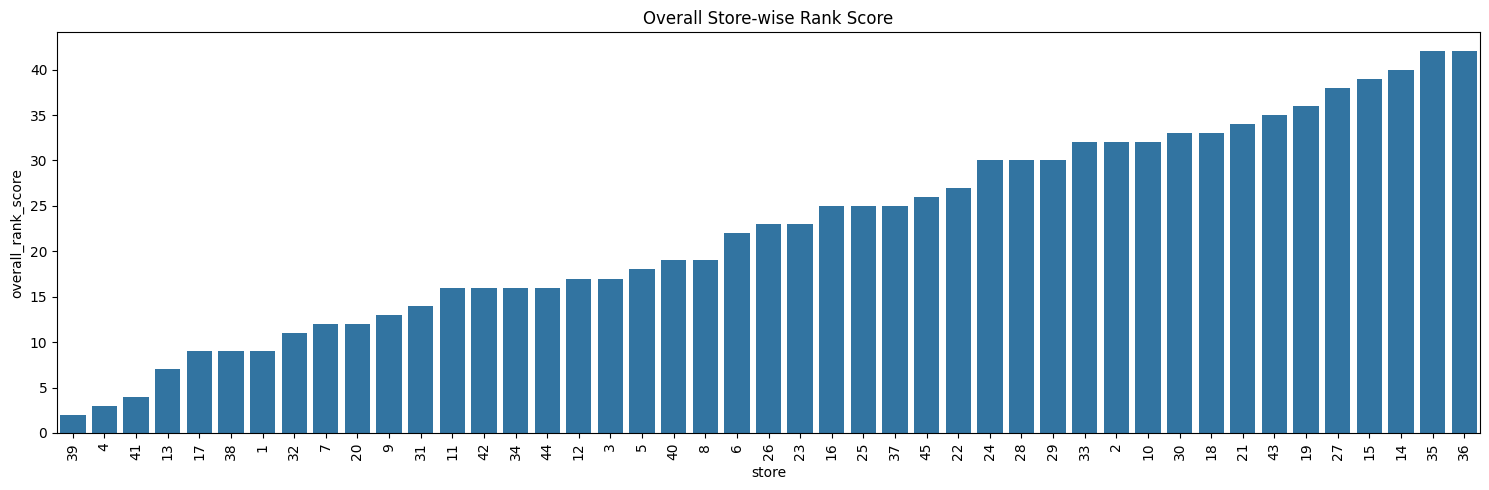

In [229]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='overall_rank_score', ascending=True).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='overall_rank_score',
    order=sorted_df['store']
)
plt.title('Overall Store-wise Rank Score')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.grid(True)
plt.show()

### Conclusions

- By analyzing the composite score rank, stores [39, 4, 41, 13] are the top 5 performers in terms of sales and stores [15, 27, 14, 36, 35] seem to be the worst performers.

In [233]:
best_stores = ['39', '4', '41', '13', '17']
worst_stores = ['36', '35', '14', '15', '27']


def plot_store_sales(df: pd.DataFrame, store_list: list[str],
                     title: str) -> None:
  num_stores = len(store_list)
  fig, axes = plt.subplots(
      num_stores,
      1,
      figsize=(11, 2.5 * num_stores), 
      sharex=True) 

  colors = sns.color_palette(
      "Set1", num_stores
  )  # Use a visually appealing color palette

  for i, store in enumerate(store_list):
    store_data = df[df['store'] == store]
    ax = axes[i]
    sns.lineplot(
        x='date',
        y='weekly_sales',
        data=store_data,
        ax=ax,
        label=f'Store {store}',
        color=colors[i],
        linewidth=1.5)  # Adjust line width for better visibility
    ax.set_title(f'Weekly Sales - Store {store}', fontsize=12)
    ax.set_ylabel('Weekly Sales', fontsize=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)  # Add grid for easier reading

  # Customize overall plot appearance
  fig.suptitle(title, fontsize=16, y=0.95)  # Overall title
  plt.xlabel('Date', fontsize=10)  # Shared x-axis label
  plt.tight_layout(
      rect=[0, 0.03, 1, 0.92]
  )  # Adjust layout to prevent overlapping titles
  plt.show()

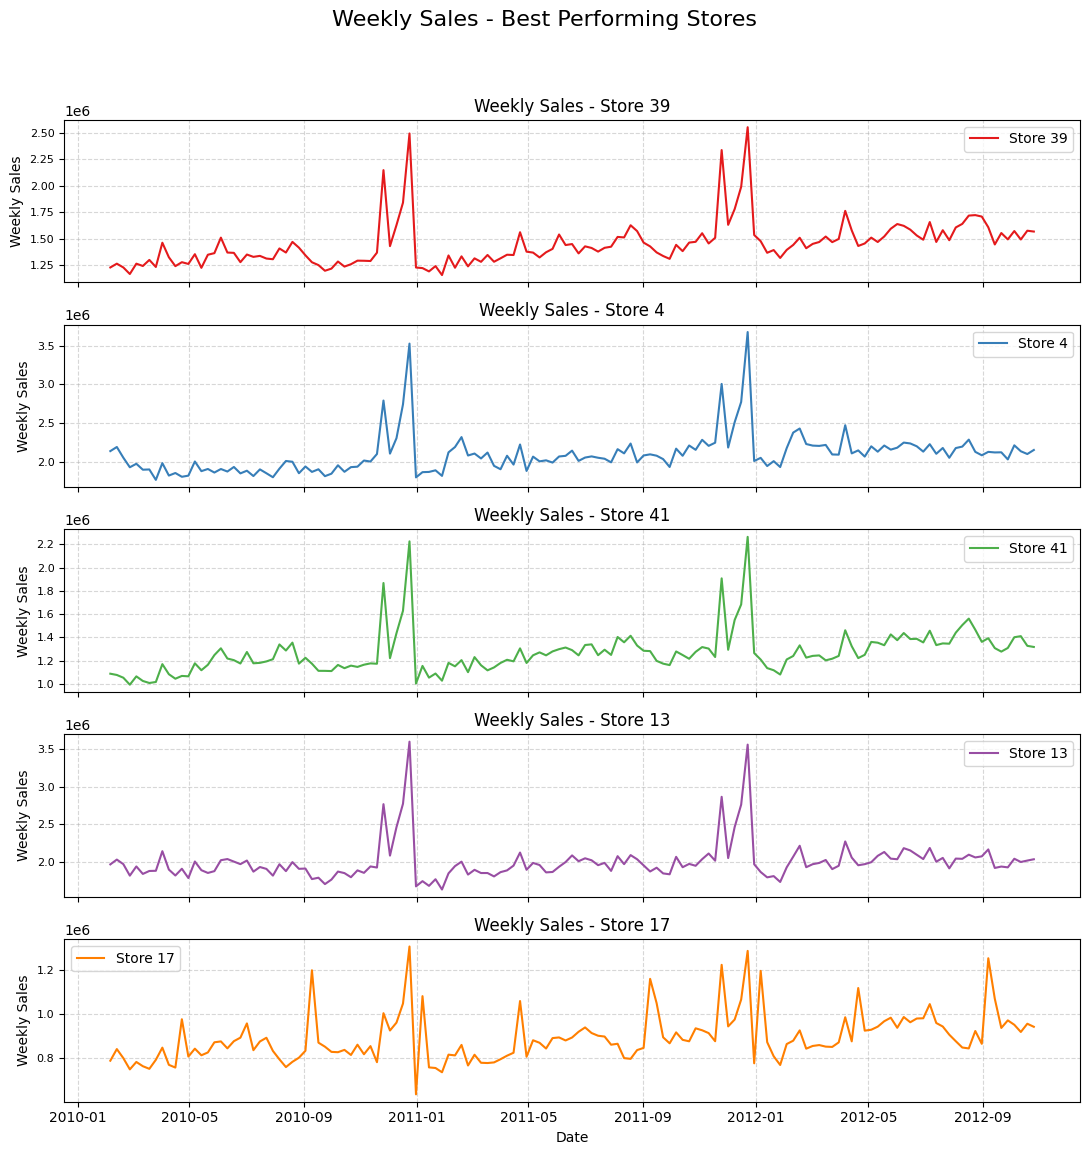

In [234]:
# Plotting for best performing stores
plot_store_sales(df, best_stores, 'Weekly Sales - Best Performing Stores')

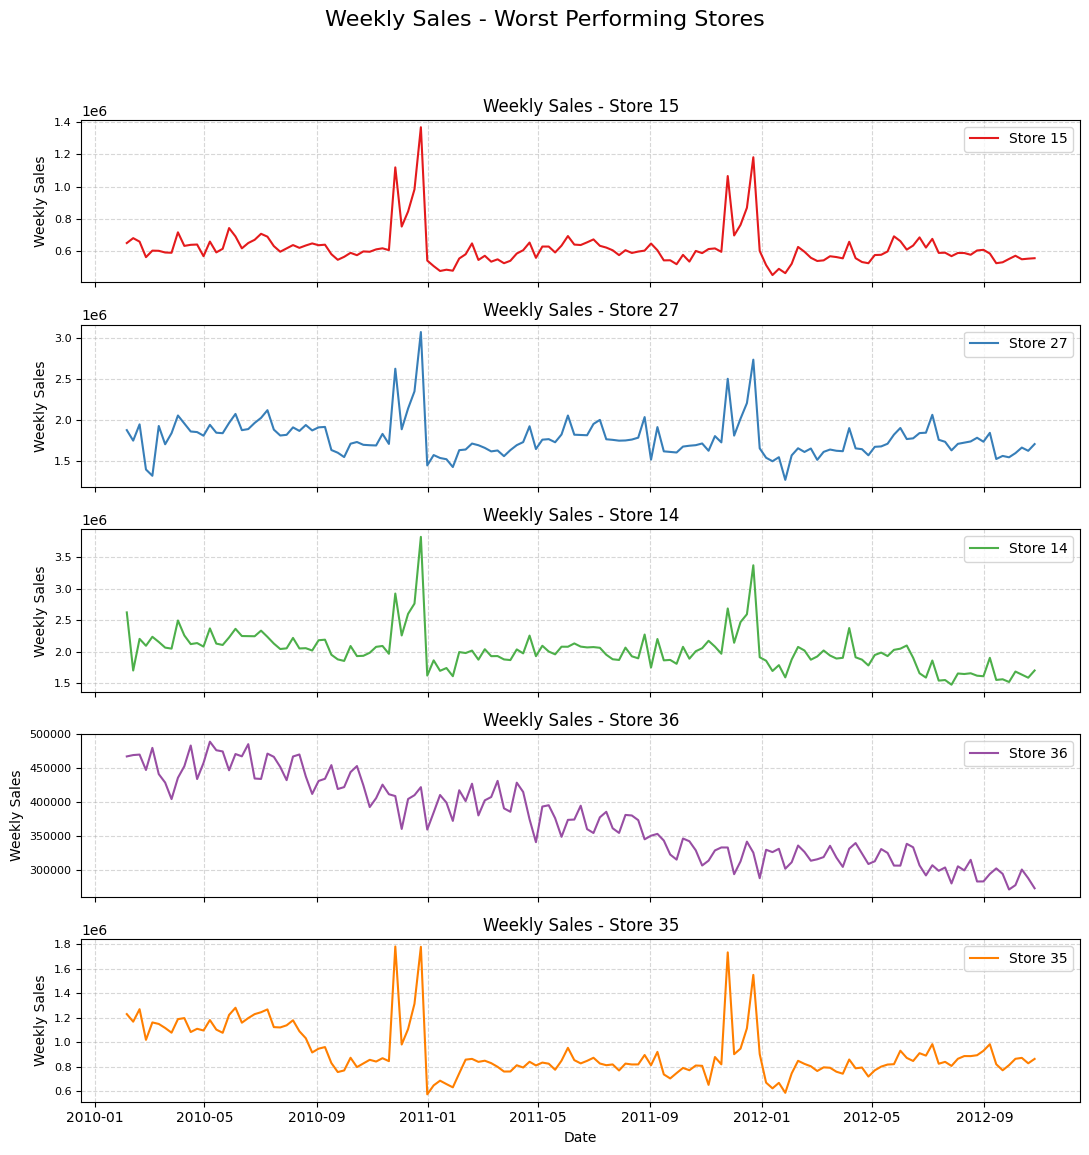

In [232]:
# Plotting for worst performing stores
plot_store_sales(df, worst_stores, 'Weekly Sales - Worst Performing Stores')

## Checking correlation between unemployment, fuel_price and cpi

In [ ]:
store = '2'
df_store = df.loc[df['store'] == store].copy()

# Create a scatter plot using Matplotlib
plt.figure(figsize=(11, 4))

# Create a scatter plot
scatter = plt.scatter(df_store['cpi'], df_store['fuel_price'], 
                      c=df_store['unemployment'], cmap='viridis', 
                      edgecolor='w', s=100)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Unemployment')

# Add labels and title
plt.title('Scatter Plot of CPI vs Fuel Price with Unemployment for store ' + store)
plt.xlabel('CPI')
plt.ylabel('Fuel Price')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

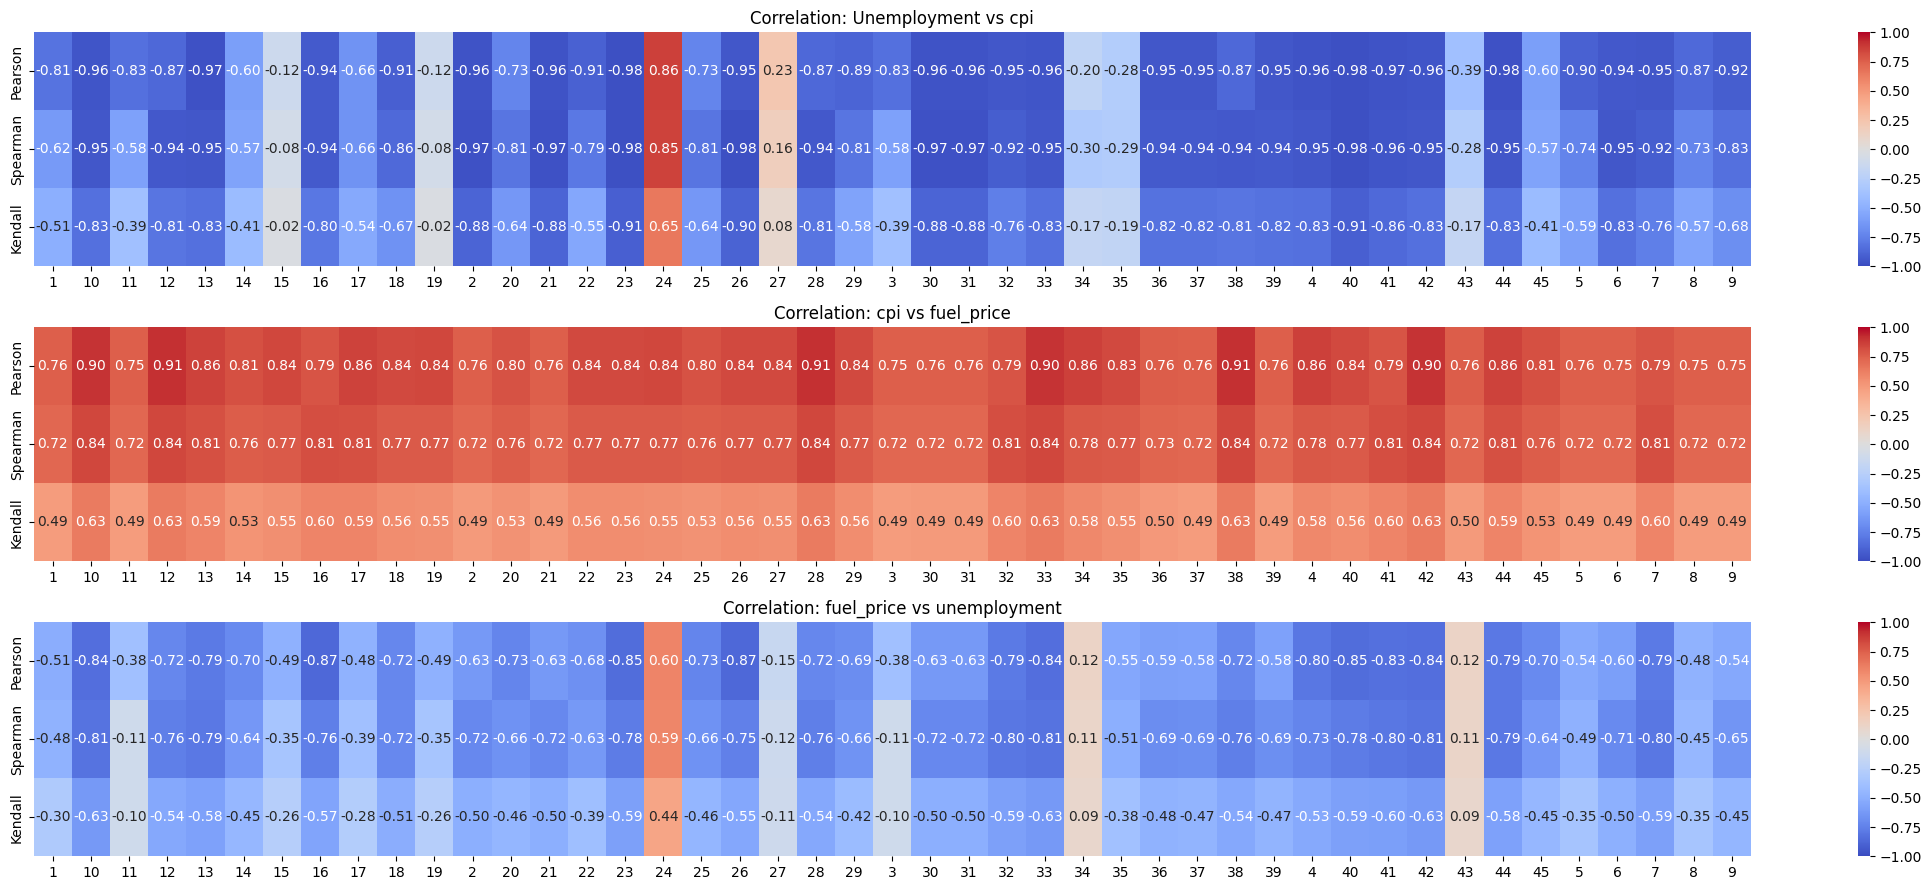

In [31]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
unemployment_cpi = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
cpi_fuel_price = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
fuel_price_unemployment = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Compute correlations (Unemployment vs CPI)
    unemployment_cpi.loc['Pearson', store] = df_store['unemployment'].corr(df_store['cpi'], method='pearson')
    unemployment_cpi.loc['Spearman', store] = df_store['unemployment'].corr(df_store['cpi'], method='spearman')
    unemployment_cpi.loc['Kendall', store] = df_store['unemployment'].corr(df_store['cpi'], method='kendall')

    # Compute correlations (CPI vs Fuel Price)
    cpi_fuel_price.loc['Pearson', store] = df_store['cpi'].corr(df_store['fuel_price'], method='pearson')
    cpi_fuel_price.loc['Spearman', store] = df_store['cpi'].corr(df_store['fuel_price'], method='spearman')
    cpi_fuel_price.loc['Kendall', store] = df_store['cpi'].corr(df_store['fuel_price'], method='kendall')
    
    # Compute correlations (Fuel Price vs Unemployment)
    fuel_price_unemployment.loc['Pearson', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='pearson')
    fuel_price_unemployment.loc['Spearman', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='spearman')
    fuel_price_unemployment.loc['Kendall', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='kendall')


# Convert to float type (for better plotting)
unemployment_cpi = unemployment_cpi.astype(float)
cpi_fuel_price = cpi_fuel_price.astype(float)
fuel_price_unemployment = fuel_price_unemployment.astype(float)


# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(22, 9), gridspec_kw={'height_ratios': [1, 1, 1]})

# Unemployment vs cpi Heatmap
sns.heatmap(unemployment_cpi, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation: Unemployment vs cpi")

# CPI vs fuel_price Heatmap
sns.heatmap(cpi_fuel_price, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation: cpi vs fuel_price")

# Fuel Price vs unemployment Heatmap
sns.heatmap(fuel_price_unemployment, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[2], vmin=-1, vmax=1)
axes[2].set_title("Correlation: fuel_price vs unemployment")

# Adjust layout
plt.tight_layout()
plt.show()

In [50]:

# Define the extra percentiles you want
extra_percentiles = [0.05, 0.10, 0.15, 0.20, 0.25, 0.75, 0.80, 0.85, 0.90, 0.95]

# Compute the descriptive statistics including the extra percentiles
desc_unemployment_cpi = (
    unemployment_cpi.loc["Pearson"]
    .describe(percentiles=extra_percentiles)
    .reset_index()
    .rename(columns={"Pearson": "unemployment vs cpi"})
)
desc_cpi_fuel_price = (
    cpi_fuel_price.loc["Pearson"]
    .describe(percentiles=extra_percentiles)
    .reset_index()
    .rename(columns={"Pearson": "cpi vs fuel price"})
)
desc_fuel_price_unemployment = (
    fuel_price_unemployment.loc["Pearson"]
    .describe(percentiles=extra_percentiles)
    .reset_index()
    .rename(columns={"Pearson": "fuel price vs unemployment"})
)

# Merge the three DataFrames on the 'index' column
(
    desc_unemployment_cpi.merge(desc_cpi_fuel_price, on="index")
    .merge(desc_fuel_price_unemployment, on="index")
    .set_index("index")
    .drop(labels=["count"], axis=0)
)


unemployment vs cpi  cpi vs fuel price  fuel price vs unemployment
index                                                                    
mean             -0.754107           0.814384                   -0.597719
std               0.374793           0.052361                    0.288258
min              -0.977855           0.754134                   -0.873024
5%               -0.974720           0.754206                   -0.851177
10%              -0.964682           0.754895                   -0.839678
15%              -0.961946           0.755325                   -0.833261
20%              -0.961946           0.755369                   -0.795181
25%              -0.960864           0.755861                   -0.787313
50%              -0.909667           0.809476                   -0.679553
75%              -0.732422           0.836295                   -0.538876
80%              -0.648679           0.857948                   -0.485188
85%              -0.513644           0.859545                   -0.479774
90%              -0.231817           0.904258                   -0.384444
95%              -0.118865           0.909358                    0.066221
max               0.862500           0.910633                    0.596955

### Observations
1. CPI and Fuel price are strongly positively correlated with each other for ALL stores with average Pearson correlation coefficient of 0.814. This is intuitive because fuel pice is generally considered when calculating CPI.
2. Unemployment and CPI are negatively correlated for most stores. For 75% of then stores, the correlation is greater in magnitude than 0.73 and for 85% of the stores it's greater in magnitude than 0.51. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.86
3. Fuel Price and Unemployment are negatively correlated for most stores. This correltion isn't as strong as Unemployment and CPI. For 75% of then stores, the correlation is greater in magnitude than 0.53. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.6

## PCA with CPI, Fuel Price, and Unemployment

### Why?
- PCA is used for dimensionality reduction. And while it may seem like we don't have that high dimensional data with only 5 features, but the fact that we are forecasting the sales store wise makes it so that we have only 143 rows/observations per store with 5 features.
- And that's too little data for us to consider 5 exogenous variables. So we can try to reduce the dimensionality of our data and see if it works.



In [52]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Group by store
stores = df['store'].unique()

# Let's create a structure to hold the PCA results for each store
store_pca_results = {}

for store_id in stores:
    # Filter data for that store
    df_store = df[df['store'] == store_id].copy()
    
    # Sort by date to ensure proper time ordering (if not already)
    df_store.sort_values(by='date', inplace=True)
    
    # 2. Extract the 3 correlated features
    X = df_store[['cpi', 'fuel_price', 'unemployment']].values
    
    # 3. Standardize the features (very important for PCA!)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. Apply PCA
    pca = PCA(n_components=2)  # We'll fit up to 3, but we might keep fewer
    pca.fit(X_scaled)
    
    # 5. Get the transformed principal components
    # shape: (num_weeks, 3)
    X_pca = pca.transform(X_scaled)
    
    # 6. Check explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # We can store these results
    store_pca_results[store_id] = {
        'pca_object': pca,
        'scaler': scaler,
        'explained_variance': explained_variance,
        'principal_components': X_pca
    }

    # OPTIONAL: You can add these principal components back to df_store
    # if you want them as features in your next model.
    df_store['PC1'] = X_pca[:, 0]
    df_store['PC2'] = X_pca[:, 1]
    # df_store['PC3'] = X_pca[:, 2]
    
    # Then you might store or export df_store with these new columns
    # e.g., store the modified DataFrame in a dictionary or list
    store_pca_results[store_id]['df_with_pcs'] = df_store


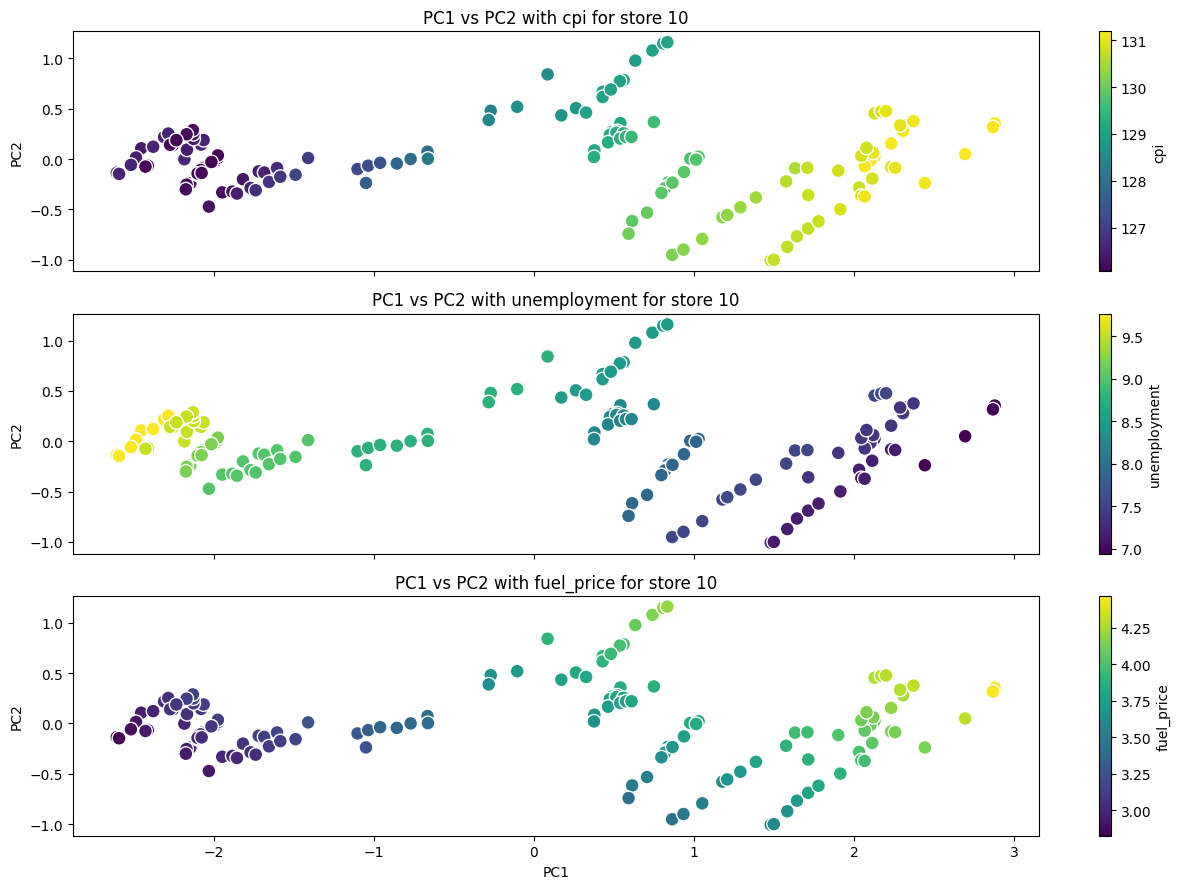

In [60]:
store = "10"
df_store = store_pca_results.get(store).get("df_with_pcs").copy()

# Define the hue variables
hue_variables = ["cpi", "unemployment", "fuel_price"]

# Create subplots
fig, axes = plt.subplots(
    len(hue_variables), 1, figsize=(13, 3 * len(hue_variables)), sharex=True, sharey=True
)

# Loop through hue variables and create scatter plots
for i, hue_variable in enumerate(hue_variables):
    ax = axes[i]  # Get the current subplot

    # Create a scatter plot
    scatter = ax.scatter(
        df_store["PC1"],
        df_store["PC2"],
        c=df_store[hue_variable],
        cmap="viridis",
        edgecolor="w",
        s=100,
    )

    # Add color bar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(hue_variable)

    # Add labels and title
    ax.set_title(f"PC1 vs PC2 with {hue_variable} for store {store}")
    ax.set_ylabel("PC2")  # Y-axis label for each subplot

# Set common X-axis label for the last subplot
axes[-1].set_xlabel("PC1")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

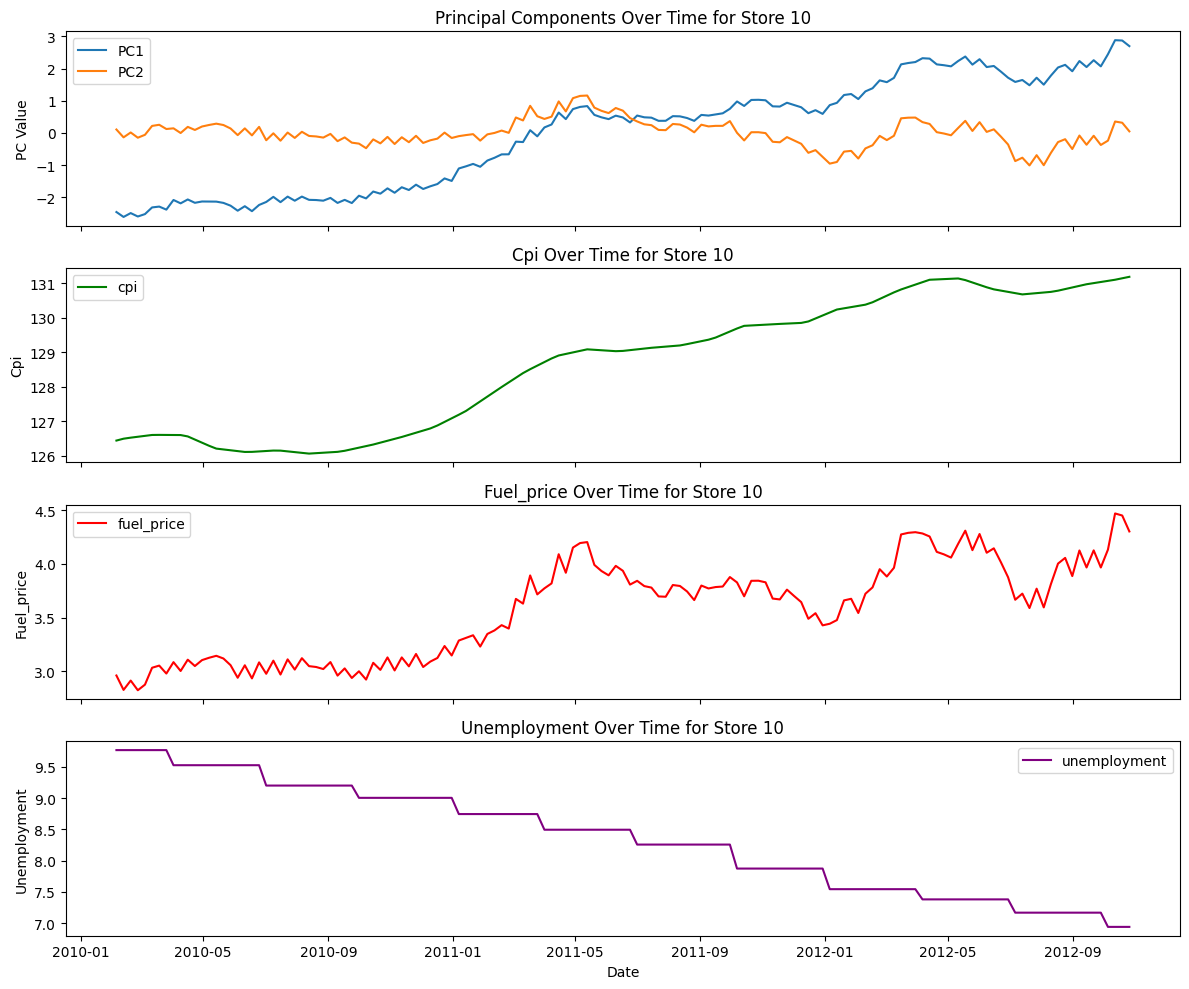

In [77]:
def plot_pcs_time(store_id):
    df_store = store_pca_results[store_id]["df_with_pcs"]
    metrics = ["cpi", "fuel_price", "unemployment"]

    # Create subplots
    fig, axes = plt.subplots(len(metrics) + 1, 1, figsize=(12, 2.5 * (len(metrics) + 1)), sharex=True)

    # Plot PC1 and PC2
    axes[0].plot(df_store["date"], df_store["PC1"], label="PC1")
    axes[0].plot(df_store["date"], df_store["PC2"], label="PC2")
    axes[0].set_title(f"Principal Components Over Time for Store {store_id}")
    axes[0].set_ylabel("PC Value")
    axes[0].legend()

    # Plot metrics
    colors = ["green", "red", "purple"]  # Define colors for each metric
    for i, metric in enumerate(metrics):
        axes[i + 1].plot(df_store["date"], df_store[metric], label=metric, color=colors[i])
        axes[i + 1].set_title(f"{metric.capitalize()} Over Time for Store {store_id}")
        axes[i + 1].set_ylabel(metric.capitalize())
        axes[i + 1].legend()

    # Set x label for the last subplot
    axes[-1].set_xlabel("Date")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


plot_pcs_time("10")

In [78]:
pc1_explained_var = []
pc2_explained_var = []

for key, value in store_pca_results.items():
    pc1_explained_var.append(value['explained_variance'][0])
    pc2_explained_var.append(value['explained_variance'][1])

explained_var = pd.DataFrame({'PC1': pc1_explained_var, 'PC2': pc2_explained_var})
explained_var['total'] = explained_var['PC1'] + explained_var['PC2']

explained_var.describe()

PC1        PC2      total
count  45.000000  45.000000  45.000000
mean    0.837000   0.142385   0.979385
std     0.087777   0.082199   0.015858
min     0.603096   0.056002   0.933382
25%     0.803809   0.087022   0.972884
50%     0.857133   0.135813   0.983690
75%     0.895186   0.158574   0.990703
max     0.934701   0.365466   0.994236

### Conclusion/Observations

- The 3 features cpi, unemployment and fuel_price are reduced to 2 principal components which on average (across all stores) explains 97% variance across the 3 features.
- The minimum of this total explained various only drops to 93% across all stores. Which is pretty good.
- When I tried reducing the features to just 1 principal component, I got worse results where on average (across all stores) the variance explained was only 83%

## Stationarity

- ADF test
- KPSS test

### Transformations

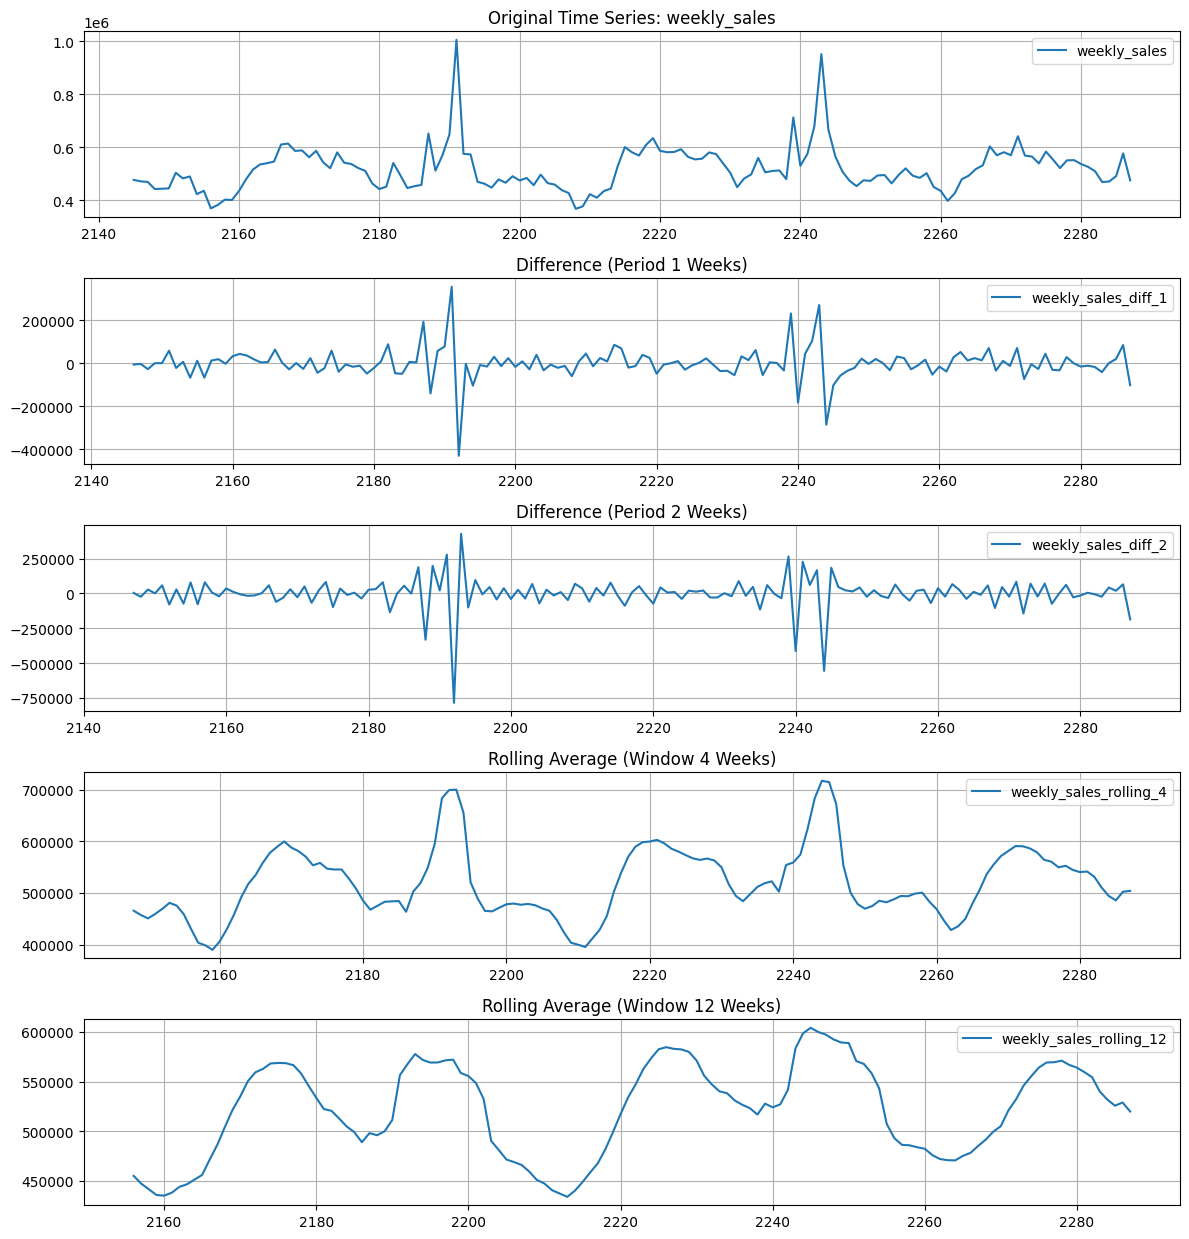

In [139]:
store = '16'
df_store = df.loc[df['store'] == store].copy()

time_series_col = 'weekly_sales'
periods_diff = [1, 2]  # Number of times for differencing
window_sizes = [4, 12]  # Number of weeks for rolling averages

# Create difference transformations
df_store[f"{time_series_col}_diff_1"] = df_store[time_series_col].diff(periods=1).copy()
df_store[f"{time_series_col}_diff_2"] = df_store[f"{time_series_col}_diff_1"].diff(periods=1).copy()

# Create rolling average transformations
for window in window_sizes:
    df_store[f"{time_series_col}_rolling_{window}"] = (
        df_store[time_series_col].rolling(window=window).mean()
    ).copy()

# Plotting
num_plots = 1 + len(periods_diff) + len(window_sizes)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2.5 * num_plots))  # Adjusted figsize

# Plot original time series
axes[0].plot(df_store.index, df_store[time_series_col], label=time_series_col)
axes[0].set_title(f"Original Time Series: {time_series_col}")
axes[0].legend()
axes[0].grid(True)


# Plot difference transformations
for i, period in enumerate(periods_diff):
    col_name = f"{time_series_col}_diff_{period}"
    axes[i + 1].plot(df_store.index, df_store[col_name], label=col_name)
    axes[i + 1].set_title(f"Difference (Period {period} Weeks)")
    axes[i + 1].legend()
    axes[i + 1].grid(True)

# Plot rolling average transformations
for i, window in enumerate(window_sizes):
    col_name = f"{time_series_col}_rolling_{window}"
    axes[len(periods_diff) + i + 1].plot(
        df_store.index, df_store[col_name], label=col_name
    )
    axes[len(periods_diff) + i + 1].set_title(
        f"Rolling Average (Window {window} Weeks)"
    )
    axes[len(periods_diff) + i + 1].legend()
    axes[len(periods_diff) + i + 1].grid(True)

plt.tight_layout()
plt.show()


#### Observations

- From manual inspection atleast, 1st and 2nd differencing make the series mostly stationary. However, the holiday effect is still present.
- Rolling averages are not helping much.

### Seasonal Decomposition of Differences

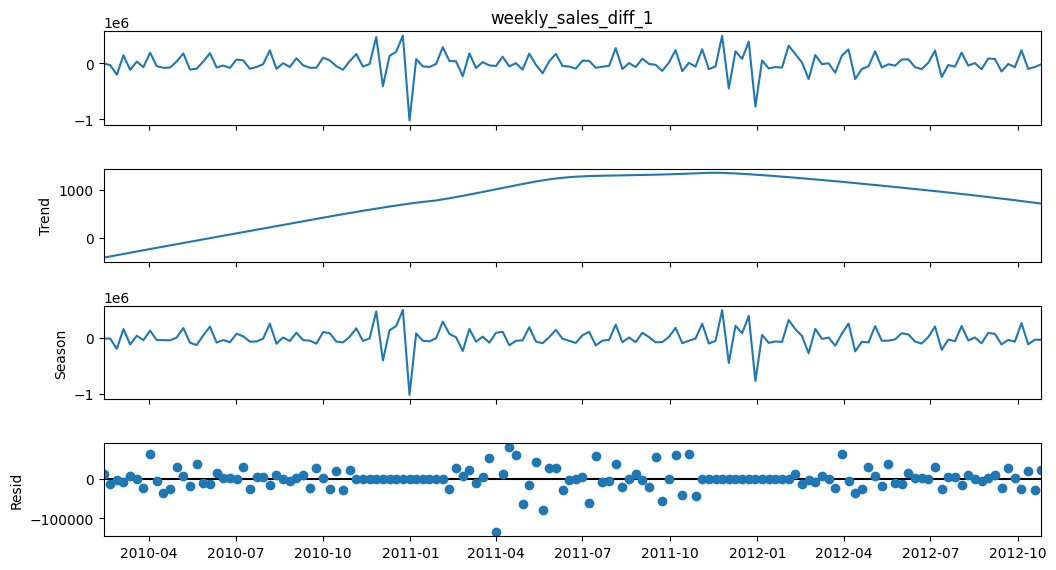

In [93]:
store = '1'
df_store = df.loc[df['store'] == store].copy()
df_store.set_index('date', inplace=True)

time_series_col = 'weekly_sales'
periods_diff = [1, 2]  # Number of weeks for differencing
window_sizes = [2, 4, 6]  # Number of weeks for rolling averages

# Create difference transformations
df_store[f"{time_series_col}_diff_1"] = df_store[time_series_col].diff(periods=1).copy()
df_store[f"{time_series_col}_diff_2"] = df_store[f"{time_series_col}_diff_1"].diff(periods=1).copy()

# Create rolling average transformations
for window in window_sizes:
    df_store[f"{time_series_col}_rolling_{window}"] = (
        df_store[time_series_col].rolling(window=window).mean()
    ).copy()

y = df_store[f"{time_series_col}_diff_1"].dropna()

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, robust=False)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(12, 6)

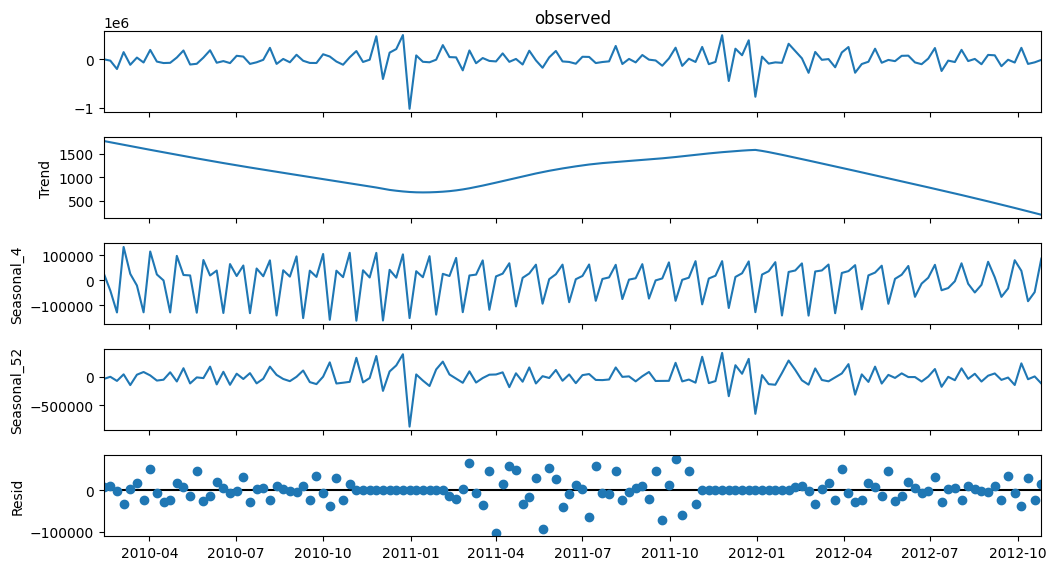

In [97]:
mstl = MSTL(y, periods=[4, 52], iterate=5)
result = mstl.fit()

fig = result.plot()
fig.set_size_inches(12, 6)
plt.show()

#### Observations

- STL decomposition of diff 1 shows good results. It may look like there's a trend, but comparing it's range to the range of sales diff 1, it is insignificant.
- MSTL would have been promising for seasonal periods of 5 (1 month) and 52 weeks (1 year). But, since our years are not fully divisible into whole weeks, it is difficult to capture seasonality. Same for monthly seasonality.

### Seasonal Differencing

In [111]:

store_number = "2"

store_df = df[df["store"] == store_number].copy()
store_df = store_df.sort_values(by="date")
store_df["seasonal_diff_52"] = store_df["weekly_sales"].diff(periods=52)
store_df["seasonal_diff_53"] = store_df["weekly_sales"].diff(periods=53)

# Define dark blue color
dark_blue = "#00008B"

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 13), sharex=True)

# Function to add holiday annotations
def add_holiday_annotations(ax, df):
    holiday_dates = df.loc[df["holiday_flag"], 'date']
    for date in holiday_dates:
        ax.axvline(
            x=date, color="red", linestyle="--", alpha=0.5, label="Holiday" if date == holiday_dates.iloc[0] else None,
            linewidth=2,
        )


# Plot original weekly sales
sns.lineplot(
    x="date",
    y="weekly_sales",
    data=store_df,
    ax=axes[0],
    label="Original Weekly Sales",
    color=dark_blue,
)
add_holiday_annotations(axes[0], store_df)
axes[0].set_title(f"Weekly Sales for Store {store_number}")
axes[0].set_ylabel("Sales")
axes[0].grid(True)
axes[0].legend()


# Plot seasonal difference (52 weeks)
sns.lineplot(
    x="date",
    y="seasonal_diff_52",
    data=store_df,
    ax=axes[1],
    label="Seasonal Difference (52 weeks)",
    color=dark_blue,
)
add_holiday_annotations(axes[1], store_df)
axes[1].set_title(f"Seasonal Difference (52 weeks) for Store {store_number}")
axes[1].set_ylabel("Sales Difference")
axes[1].grid(True)
axes[1].legend()

# Plot seasonal difference (53 weeks)
sns.lineplot(
    x="date",
    y="seasonal_diff_53",
    data=store_df,
    ax=axes[2],
    label="Seasonal Difference (53 weeks)",
    color=dark_blue,
)
add_holiday_annotations(axes[2], store_df)
axes[2].set_title(f"Seasonal Difference (53 weeks) for Store {store_number}")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Sales Difference")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#### Observations

- Holidays in this case repeat every 365 days (a year). But, unfortunately, we have weekly data and can only use 52 or 53 weeks for differencing instead of something like 52.5 days which would be 1 proper year.
- That's why, we can observe few peculiarities: for some holidays, the 52 week differencing nullifies the holiday effect boost (excluding the general updards trend ofcourse) and for the rest, it doesn't nullify the effect due to reasons mentioned in previous point. 
- Same for 53 weeks differencing. For some holidays, it nullifies the holiday effect boost and for the rest, it doesn't.

### ADF and KPSS test for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# Define helper functions for ADF and KPSS tests
def run_adf(series):
    result = adfuller(series, autolag='AIC')
    return {
        "adf_stat": result[0],
        "p_value": result[1],
        "n_lags": result[2],
        "n_obs": result[3],
        "crit_1%": result[4].get("1%"),
        "crit_5%": result[4].get("5%"),
        "crit_10%": result[4].get("10%"),
        "ic_best": result[5]  # information criterion used for lag selection
    }

def run_kpss(series, regression="c"):
    result = kpss(series, regression=regression, nlags="auto")
    return {
        "kpss_stat": result[0],
        "p_value": result[1],
        "n_lags": result[2],
        "crit_10%": result[3].get("10%"),
        "crit_5%": result[3].get("5%"),
        "crit_2.5%": result[3].get("2.5%"),
        "crit_1%": result[3].get("1%")
    }

# Containers for storing results for each test and differencing order
adf_diff1_results = []
adf_diff2_results = []
kpss_diff1_results = []
kpss_diff2_results = []

for store in df["store"].cat.categories:
    # Subset data for the store and sort by date
    store_data = df[df["store"] == store].sort_values("date")
    sales_series = store_data["weekly_sales"]

    # Compute first and second differences (drop the NaN at the beginning)
    diff1 = sales_series.diff(1).dropna()
    diff2 = sales_series.diff(2).dropna()

    # Run tests and capture the results.
    # Using try/except to catch any errors (e.g., if the series is too short)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        adf_res1 = run_adf(diff1)
        adf_res2 = run_adf(diff2)
        kpss_res1 = run_kpss(diff1, regression="c")
        kpss_res2 = run_kpss(diff2, regression="c")

    # Add a reference to the store (to facilitate grouping later)
    adf_res1["store"] = store
    adf_res2["store"] = store
    kpss_res1["store"] = store
    kpss_res2["store"] = store

    adf_diff1_results.append(adf_res1)
    adf_diff2_results.append(adf_res2)
    kpss_diff1_results.append(kpss_res1)
    kpss_diff2_results.append(kpss_res2)

# Create DataFrames (using store as index)
adf_diff1_df = pd.DataFrame(adf_diff1_results).set_index("store")
adf_diff2_df = pd.DataFrame(adf_diff2_results).set_index("store")
kpss_diff1_df = pd.DataFrame(kpss_diff1_results).set_index("store")
kpss_diff2_df = pd.DataFrame(kpss_diff2_results).set_index("store")

# Get descriptive summaries for each test and differencing order.
# The describe() output uses as index: count, mean, std, min, 25%, 50%, 75%, max.
adf_diff1_summary = adf_diff1_df.describe()
adf_diff2_summary = adf_diff2_df.describe()
kpss_diff1_summary = kpss_diff1_df.describe()
kpss_diff2_summary = kpss_diff2_df.describe()

#### ADF for 1st order differences

In [130]:
adf_diff1_summary

adf_stat       p_value     n_lags       n_obs    crit_1%    crit_5%  \
count  45.000000  4.500000e+01  45.000000   45.000000  45.000000  45.000000   
mean   -6.888685  1.637536e-04   6.733333  134.266667  -3.480035  -2.883326   
std     1.601953  5.246314e-04   2.480836    2.480836   0.000956   0.000416   
min   -13.345453  5.807075e-25   2.000000  127.000000  -3.482920  -2.884580   
25%    -7.487731  4.591485e-11   5.000000  134.000000  -3.480119  -2.883362   
50%    -7.053856  5.438761e-10   7.000000  134.000000  -3.480119  -2.883362   
75%    -6.567946  8.070202e-09   7.000000  136.000000  -3.479372  -2.883037   
max    -3.812654  2.780473e-03  14.000000  139.000000  -3.478294  -2.882568   

        crit_10%      ic_best  
count  45.000000    45.000000  
mean   -2.578388  3278.859720  
std     0.000222   231.917915  
min    -2.579058  2725.440942  
25%    -2.578407  3208.775174  
50%    -2.578407  3339.947073  
75%    -2.578234  3428.869715  
max    -2.577983  3544.995400

##### Observations

- Maximum p-value for the storewise sales is < 0.0027 which is obviously very low than the 0.05 threshold.
- The max ADF statistic value is lower than the minimum value of 5% critical value. That implies, for ALL stores, the ADF test statistic is less than 5% critical value.
- Hence, for 1st order differencing, we can confidently reject the null hypothesis that the series is non-stationary for all stores.

#### ADF for 2nd order differences

In [131]:
adf_diff2_summary

adf_stat       p_value     n_lags       n_obs    crit_1%    crit_5%  \
count  45.000000  4.500000e+01  45.000000   45.000000  45.000000  45.000000   
mean   -5.915064  6.169749e-03   8.022222  131.977778  -3.480935  -2.883717   
std     1.421504  2.594016e-02   3.602328    3.602328   0.001408   0.000612   
min    -8.678118  4.359889e-14   2.000000  126.000000  -3.483346  -2.884766   
25%    -7.143230  3.282740e-10   5.000000  129.000000  -3.482088  -2.884219   
50%    -5.806791  4.496992e-07   9.000000  131.000000  -3.481282  -2.883868   
75%    -5.132804  1.203890e-05  11.000000  135.000000  -3.479743  -2.883198   
max    -2.333016  1.615407e-01  14.000000  138.000000  -3.478648  -2.882722   

        crit_10%      ic_best  
count  45.000000    45.000000  
mean   -2.578597  3262.797691  
std     0.000327   228.548549  
min    -2.579156  2720.287960  
25%    -2.578864  3192.138229  
50%    -2.578677  3324.474716  
75%    -2.578320  3412.071615  
max    -2.578065  3525.435008

In [132]:
adf_diff2_df.loc[adf_diff2_df['p_value'] > 0.05]

adf_stat   p_value  n_lags  n_obs   crit_1%   crit_5%  crit_10%  \
store                                                                    
33    -2.816371  0.055973      13    127 -3.482920 -2.884580 -2.579058   
38    -2.333016  0.161541      14    126 -3.483346 -2.884766 -2.579156   

          ic_best  
store              
33     2720.28796  
38     2848.62810

In [133]:
adf_diff2_df.loc[adf_diff2_df['adf_stat'] > adf_diff2_df['crit_5%']]

adf_stat   p_value  n_lags  n_obs   crit_1%   crit_5%  crit_10%  \
store                                                                    
33    -2.816371  0.055973      13    127 -3.482920 -2.884580 -2.579058   
38    -2.333016  0.161541      14    126 -3.483346 -2.884766 -2.579156   

          ic_best  
store              
33     2720.28796  
38     2848.62810

##### Observations

- Except for stores 33 and 38, all stores have p-value less than 0.05 threshold.
- Similary, except for stores 33 and 38, all stores have ADF statistic value less than 5% critical value.
- These stores are an exception as they don't follow the general trends and seasonality found in other stores
- So, for rest of the stores, we can confidently reject the null hypothesis and conclude that the storewise sales are stationary.

#### KPSS test for 1st difference

In [54]:
kpss_diff1_summary

kpss_stat    p_value      n_lags      crit_10%       crit_5%  \
count  45.000000  45.000000   45.000000  4.500000e+01  4.500000e+01   
mean    0.149684   0.098210   37.577778  3.470000e-01  4.630000e-01   
std     0.082114   0.009235   23.288203  5.613842e-17  5.613842e-17   
min     0.057553   0.041667   15.000000  3.470000e-01  4.630000e-01   
25%     0.105590   0.100000   25.000000  3.470000e-01  4.630000e-01   
50%     0.130501   0.100000   31.000000  3.470000e-01  4.630000e-01   
75%     0.155536   0.100000   43.000000  3.470000e-01  4.630000e-01   
max     0.500000   0.100000  141.000000  3.470000e-01  4.630000e-01   

          crit_2.5%       crit_1%  
count  4.500000e+01  4.500000e+01  
mean   5.740000e-01  7.390000e-01  
std    1.122768e-16  1.122768e-16  
min    5.740000e-01  7.390000e-01  
25%    5.740000e-01  7.390000e-01  
50%    5.740000e-01  7.390000e-01  
75%    5.740000e-01  7.390000e-01  
max    5.740000e-01  7.390000e-01

In [137]:
kpss_diff1_df.loc[kpss_diff1_df['p_value'] < 0.05]

kpss_stat   p_value  n_lags  crit_10%  crit_5%  crit_2.5%  crit_1%
store                                                                    
16           0.5  0.041667     141     0.347    0.463      0.574    0.739

In [138]:
kpss_diff1_df.loc[kpss_diff1_df['kpss_stat'] > kpss_diff1_df['crit_5%']]

kpss_stat   p_value  n_lags  crit_10%  crit_5%  crit_2.5%  crit_1%
store                                                                    
16           0.5  0.041667     141     0.347    0.463      0.574    0.739

##### Observations

- Unlike convention, for KPSS test, failure to reject null hypothesis implies that the series is stationary.
- Except for store 16, all stores have p-value more than 0.05 threshold.
- Similary, except for store16, all stores have ADF statistic value more than 5% critical value.
- This store is an exception as it doesn't follow the general trends and seasonality found in other stores
- So, for rest of the stores, we can don't have enough evidence to reject the null hypothesis and conclude that the storewise sales are stationary.

#### KPSS test for 2nd difference

In [55]:
kpss_diff2_summary

kpss_stat    p_value      n_lags      crit_10%       crit_5%  \
count  45.000000  45.000000   45.000000  4.500000e+01  4.500000e+01   
mean    0.088154   0.098704   20.377778  3.470000e-01  4.630000e-01   
std     0.088579   0.008696   23.698186  5.613842e-17  5.613842e-17   
min     0.015239   0.041667    4.000000  3.470000e-01  4.630000e-01   
25%     0.040464   0.100000   11.000000  3.470000e-01  4.630000e-01   
50%     0.065140   0.100000   15.000000  3.470000e-01  4.630000e-01   
75%     0.095313   0.100000   19.000000  3.470000e-01  4.630000e-01   
max     0.500000   0.100000  140.000000  3.470000e-01  4.630000e-01   

          crit_2.5%       crit_1%  
count  4.500000e+01  4.500000e+01  
mean   5.740000e-01  7.390000e-01  
std    1.122768e-16  1.122768e-16  
min    5.740000e-01  7.390000e-01  
25%    5.740000e-01  7.390000e-01  
50%    5.740000e-01  7.390000e-01  
75%    5.740000e-01  7.390000e-01  
max    5.740000e-01  7.390000e-01

In [140]:
kpss_diff1_df.loc[kpss_diff1_df['p_value'] < 0.05]

kpss_stat   p_value  n_lags  crit_10%  crit_5%  crit_2.5%  crit_1%
store                                                                    
16           0.5  0.041667     141     0.347    0.463      0.574    0.739

In [141]:
kpss_diff1_df.loc[kpss_diff1_df['kpss_stat'] > kpss_diff1_df['crit_5%']]

kpss_stat   p_value  n_lags  crit_10%  crit_5%  crit_2.5%  crit_1%
store                                                                    
16           0.5  0.041667     141     0.347    0.463      0.574    0.739

##### Observations

- The results for 2nd difference are same as those for 1st difference.
- Except for store 16, all stores have p-value more than 0.05 threshold.
- Similary, except for store16, all stores have ADF statistic value more than 5% critical value.
- This store is an exception as it doesn't follow the general trends and seasonality found in other stores
- So, for rest of the stores, we can don't have enough evidence to reject the null hypothesis and conclude that the storewise sales are stationary.

## Auto-correlation and Partial Autocorrelation

Plotting ACF & PACF for original


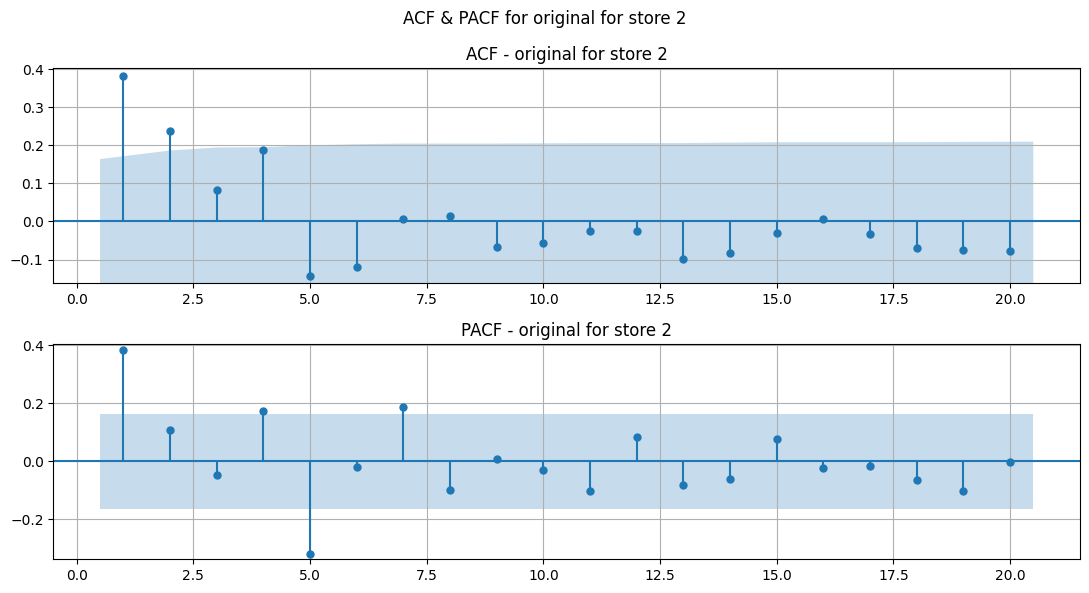

Plotting ACF & PACF for diff_1


Plotting ACF & PACF for diff_2


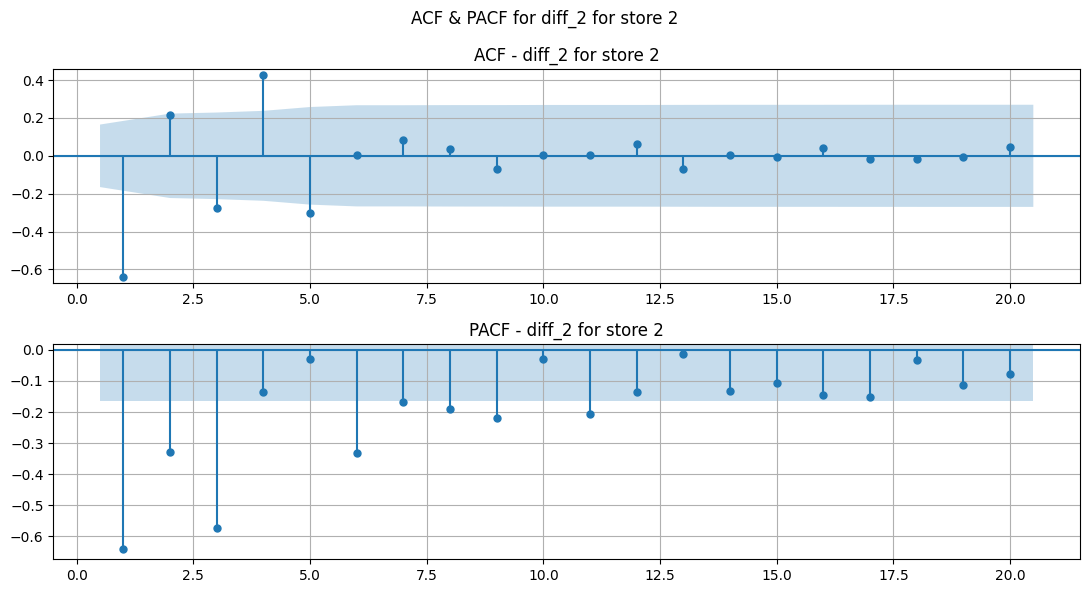

Plotting ACF & PACF for diff_3


Plotting ACF & PACF for seasonsal_diff_1


In [146]:
store = '2'
store_df = df[df['store'] == store].sort_values('date').copy()

# Set the 'date' column as the index for easier time series manipulation.
store_df = store_df.set_index('date')
sales = store_df['weekly_sales']

# Create a dictionary to store our differenced series.
series_dict = {}

# 1. Original series (no differencing)
series_dict['original'] = sales

# 2. 1 week regular differenced series (first difference)
series_dict['diff_1'] = sales.diff().dropna()

# 3. 2 times regular differenced series (second difference)
series_dict['diff_2'] = sales.diff().diff().dropna()

# 4. 3 times regular differenced series (third difference)
series_dict['diff_3'] = sales.diff().diff().diff().dropna()

# 5. 52-week seasonal differenced series.
series_dict['seasonsal_diff_1'] = sales.diff(52).dropna()


# Function to plot ACF and PACF for each series,
# adjusting the y-axis limits based on computed values,
# and enabling grid.
def plot_differenced_series(series_dict, lags=20):
    for label, series in series_dict.items():
        fig, axes = plt.subplots(2, 1, figsize=(11, 6))
        fig.suptitle(f"ACF & PACF for {label} for store {store}", fontsize=12)
        
        print(f"Plotting ACF & PACF for {label}")
        
        # Compute ACF values (skip lag 0)
        acf_vals = sm.tsa.acf(series, nlags=lags, fft=True)
        # Exclude the zero-lag (which is always 1) for axis range computation.
        nonzero_acf = acf_vals[1:]
        # Compute a margin (5% of the absolute values)
        margin_acf = 0.05 * max(abs(nonzero_acf.min()), abs(nonzero_acf.max()))
        ymin_acf = nonzero_acf.min() - margin_acf
        ymax_acf = nonzero_acf.max() + margin_acf
        
        # Plot ACF with grid enabled.
        plot_acf(series, ax=axes[0], lags=lags, zero=False)
        axes[0].set_title(f"ACF - {label} for store {store}")
        axes[0].set_ylim(ymin_acf, ymax_acf)
        axes[0].grid(True)
        
        # Compute PACF values (skip lag 0)
        pacf_vals = sm.tsa.pacf(series, nlags=lags, method='ywm')
        nonzero_pacf = pacf_vals[1:]
        margin_pacf = 0.05 * max(abs(nonzero_pacf.min()), abs(nonzero_pacf.max()))
        ymin_pacf = nonzero_pacf.min() - margin_pacf
        ymax_pacf = nonzero_pacf.max() + margin_pacf
        
        # Plot PACF with grid enabled.
        plot_pacf(series, ax=axes[1], lags=lags, method='ywm', zero=False)
        axes[1].set_title(f"PACF - {label} for store {store}")
        axes[1].set_ylim(ymin_pacf, ymax_pacf)
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()


# Plot ACF and PACF for all our series.
plot_differenced_series(series_dict)


#### Observations

From visual inspection of ACF and PACF plots for regular, 1st and 2nd order differenced sales, a few candidates for AR and MA orders are identified.

- ARIMA candidates
    - Difference 1 (d = 1)
        - AR orders (PACF) [6]
        - MA orders (ACF) [4, 5]
    - Difference 2 (d = 2)
        - AR orders (PACF) [6, 9]
        - MA orders (ACF) [4, 5]
    
- SARIMA candidates
    - Seasonal Difference 1 (D = 1)
        - AR orders (PACF) [3]
        - MA orders (ACF) [5]

From these candidates, these ARIMA and SARIMA models are selected:

- ARIMA
    - (6, 1, 4)
    - (6, 1, 5)
    - (6, 2, 4)
    - (6, 2, 5)
    - (9, 2, 4)
    - (9, 2, 5)

- SARIMA
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

## Extra EDA To Do

1. Basic EDA
   - Agg sales by year
   - Agg sales time series plot
1. Holiday Flags:
   - Check for sales 2 weeks before and after holiday flags.
   - Do all holiday flags give boost to sales?
   - Quantify which flags are driving most and least sales.
   - Does a particular holiday flag have a stronger effect on sales of few stores than others? check relative sales growth in +- 2 weeks of that holiday for all stores. Do this for all holiday flags and also other dates that drive sales but aren't marked as holiday flags
   - Use Darts libary's anamoly detector to extract actual 'holidays' events that boost sales.
2. Seasonal Trends:
   - Check if you can smooth out the seasons even more (since we only have ~3 years of data, catching seasonal patterns might be hard). Try out different seasonal periods. USe MSTL maybe?
3. Check if you can use PCA on unemployment, fuel price and CPI to see if there are any patterns.
4. Use hypothesis testing to validate linear correlation between:
   - weekly sales and cpi
   - cpi, unemployment and fuel price


**Forecasting**
1. Use Darts libary's anamoly detector + forecaster to incorporate actual 'holidays' events that boost sales in forecasting.
2. Check the Ljung-Box test for residuals.
3. Add another loss metric too?